<h1 style="font-size:35px;
        color:black;
        ">Lab 3 Accuracy of Quantum Phase Estimation</h1>

In [1]:
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter
from qiskit.tools.monitor import job_monitor
#from qiskit.ignis.mitigation.measurement import *
import matplotlib.pyplot as plt
from qiskit_aer import *

<h2 style="font-size:24px;">Part 1: Performance of Quantum Phase Estimation</h2>

<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;">Investigate the relationship between the number of qubits required for the desired accuracy of the phase estimation with high probability.</p>
</div>


The accuracy of the estimated value through Quantum Phase Estimation (QPE) and its probability of success depend on the number of qubits employed in QPE circuits. Therefore, one might want to know the necessary number of qubits to achieve the targeted level of QPE performance, especially when the phase that needs to be determined cannot be decomposed in a finite bit binary expansion. 
In Part 1 of this lab, we examine the number of qubits required to accomplish the desired accuracy and the probability of success in determining the phase through QPE.

<h3 style="font-size: 20px">1. Find the probability of obtaining the estimation for a phase value accurate to $2^{-2}$ successfully with four counting qubits.</h3> 

<h4 style="font-size: 17px">&#128211;Step A. Set up the QPE circuit with four counting qubits and save the circuit to the variable 'qc4'.  Execute 'qc4' on a Aer simulator.  Plot the histogram of the result.</h4>

Check the QPE chapter in Qiskit textbook ( go to `3. Example: Getting More Precision` section [here](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html#3.-Example:-Getting-More-Precision-) ) for the circuit.

In [2]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

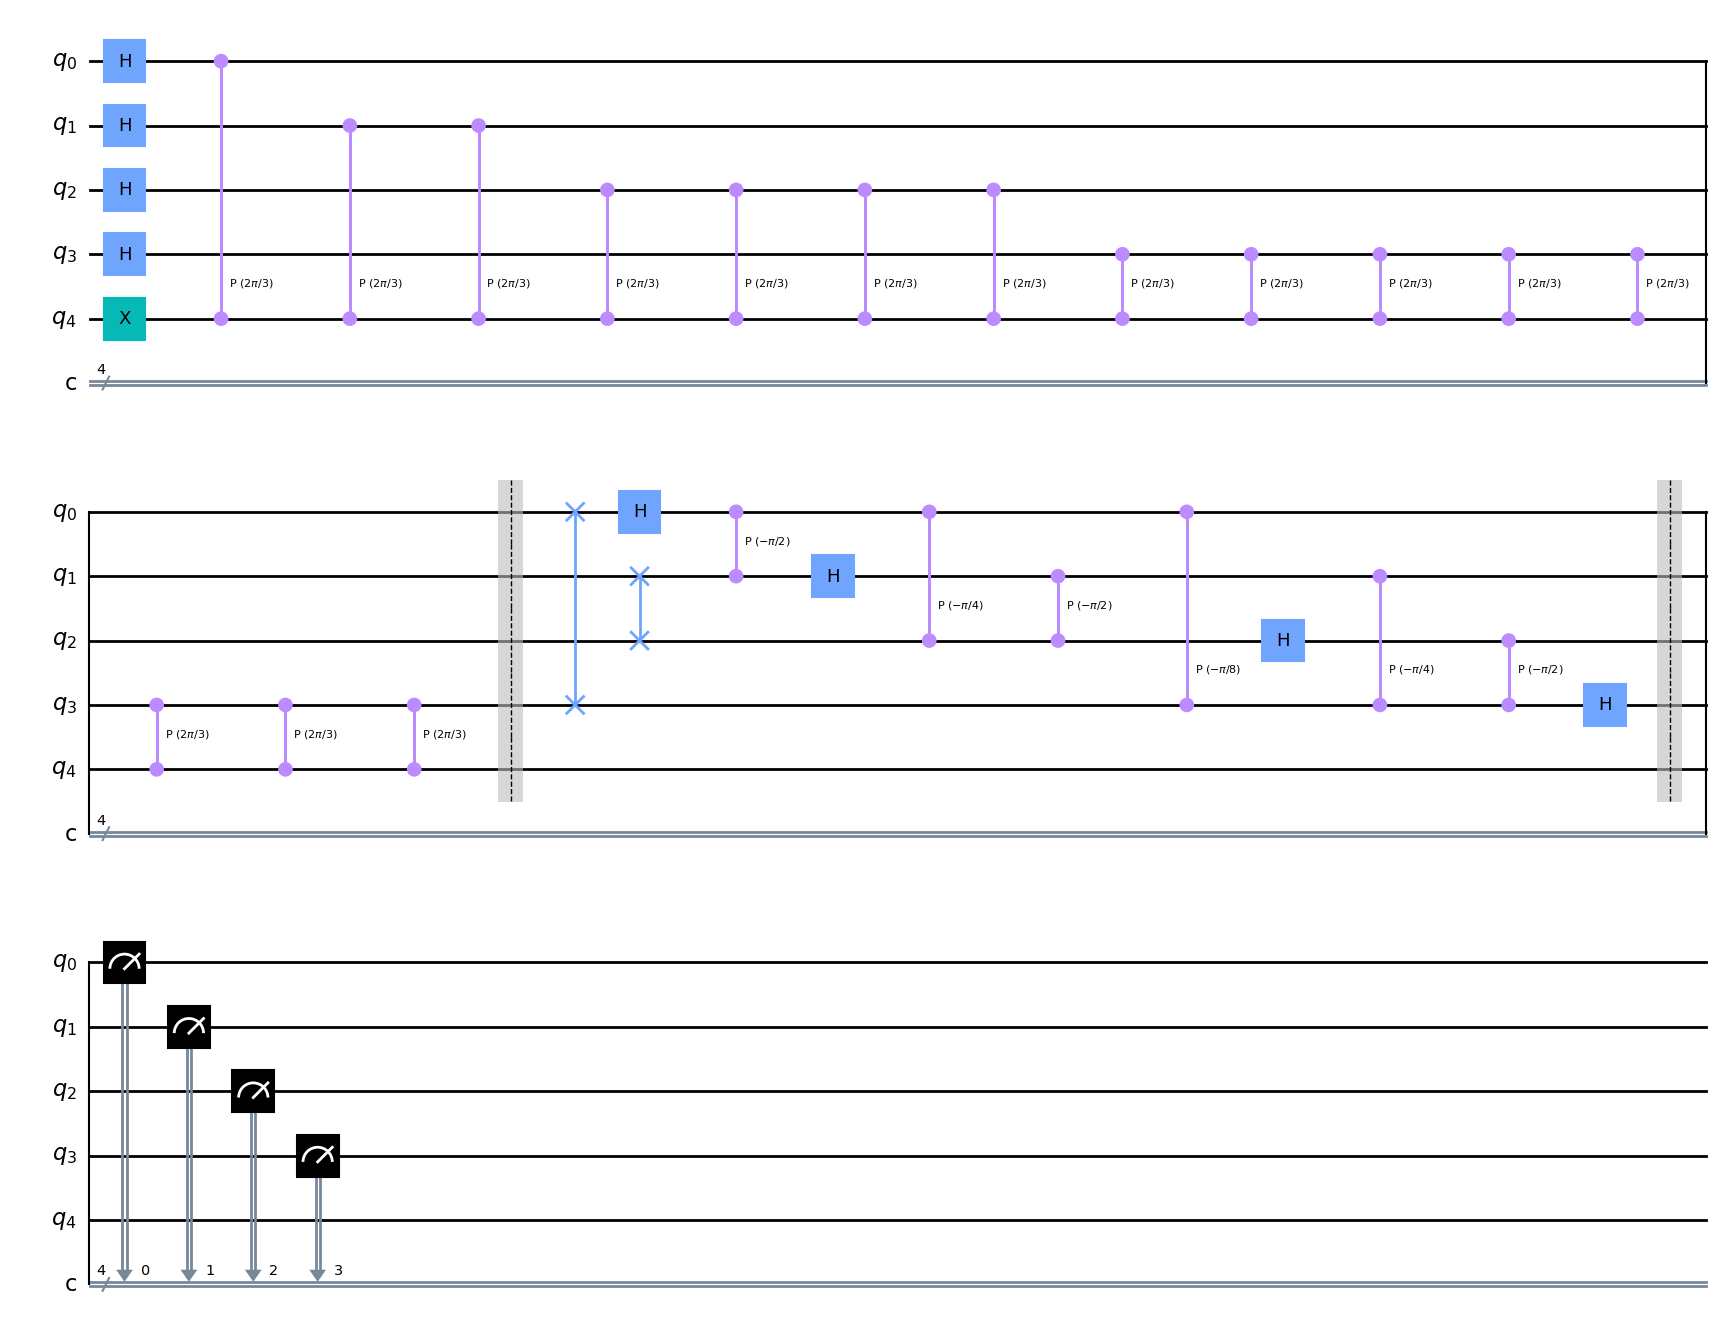

In [3]:
## Start your code to create the circuit, qc4
t = 4 # number of qubits
qc4 = QuantumCircuit(t+1,t)

#define qp rotation angle
angle = 2*np.pi/3

def qpe(no_of_qubits, theta):

    _t = no_of_qubits
    _qc = QuantumCircuit(_t+1,_t)
    #initialize |\psi> = |1> on the last qubit q_4
    _qc.x(_t)

    #apply hadmards on q_0 to q_3
    for _qubit in range(_t):
        _qc.h(_qubit)

    #apply the repeated phase shift gate
    repetitions = 1
    for counting_qubit in range(_t):
        for i in range(repetitions):
            _qc.cp(theta, counting_qubit, _t); # This is CU
        repetitions *= 2


    #define qft inverse
    def qft_dagger(qc, n):
        """n-qubit QFTdagger the first n qubits in circ"""
        # Don't forget the Swaps!
        for qubit in range(n//2):
            qc.swap(qubit, n-qubit-1)
        for j in range(n):
            for m in range(j):
                qc.cp(-np.pi/float(2**(j-m)), m, j)
            qc.h(j)

    _qc.barrier()

    qft_dagger(_qc, _t)

    _qc.barrier()
    for _qubit in range(_t):
        _cbit = _qubit
        _qc.measure(_qubit,_cbit)

    return _qc


qc4 = qpe(t, angle)


qc4.draw('mpl')

{'1101': 64, '1110': 55, '1100': 58, '0000': 75, '0010': 189, '1011': 67, '0111': 580, '0011': 279, '0110': 3455, '1000': 237, '0101': 13621, '1001': 143, '1010': 84, '1111': 75, '0001': 100, '0100': 918}
{'1101': 0.0032, '1110': 0.00275, '1100': 0.0029, '0000': 0.00375, '0010': 0.00945, '1011': 0.00335, '0111': 0.029, '0011': 0.01395, '0110': 0.17275, '1000': 0.01185, '0101': 0.68105, '1001': 0.00715, '1010': 0.0042, '1111': 0.00375, '0001': 0.005, '0100': 0.0459}


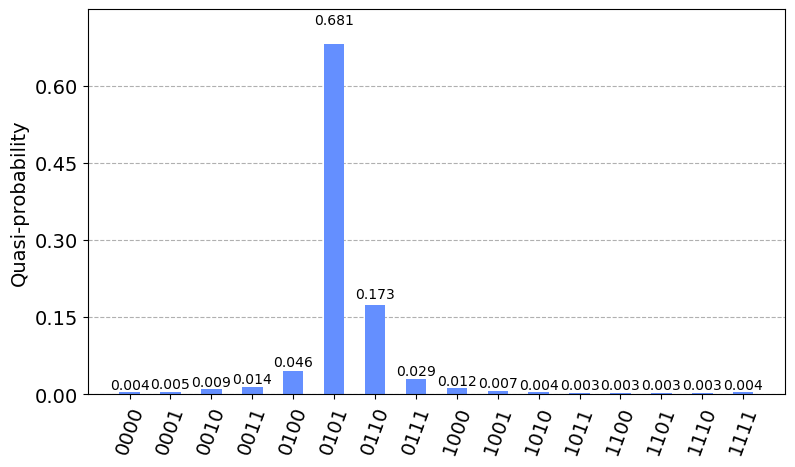

In [4]:
## Run this cell to simulate 'qc4' and to plot the histogram of the result
sim = Aer.get_backend('aer_simulator')
shots = 20000
count_qc4 = execute(qc4, sim, shots=shots).result().get_counts()
print(count_qc4)
count_qc4 = {key: count/shots for key,count in count_qc4.items()}
print(count_qc4)
plot_histogram(count_qc4, figsize=(9,5))

Having performed `Step A` successfully, you will have obtained a distribution similar to the one shown below with the highest probability at `0101` which corresponds to the estimated $\phi$ value, `0.3125`.

![](image/L3_qc4_hist.png)

Since the number of counting qubits used for the circuit is four, the best estimated value should be accurate to $\delta = 2^{-4} = 0.0625$.  However, there are multiple possible outcomes as $\theta = 1/3$ cannot be expressed in a finite number of bits, the estimation by QPE here is not always bounded by this accuracy. 

Running the following cell shows the same histogram but with all possible estimated $\phi$ values on the x-axis.

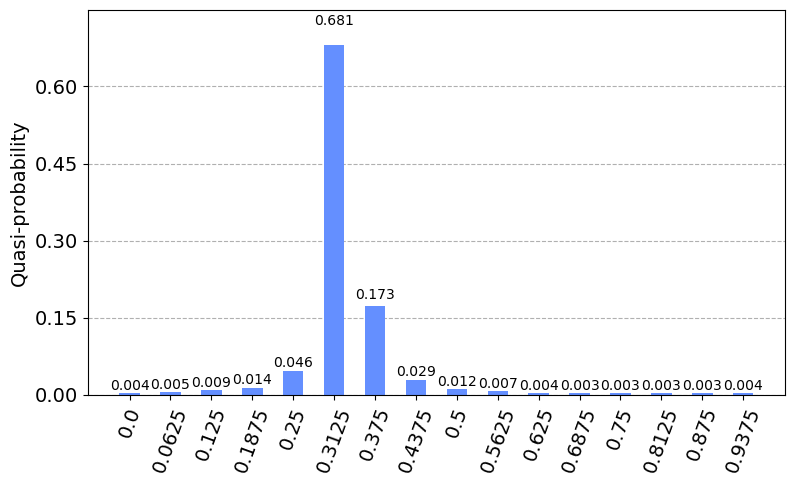

In [5]:
phi_est = np.array([round(int(key, 2)/2**t,5) for key in list(count_qc4.keys())])
key_new = list(map(str, phi_est))
count_new = dict(zip(key_new, count_qc4.values()))
plot_histogram(count_new, figsize=(9,5))

**Suppose the outcome of the final measurement is $m$, and let $b$ the best estimation which is `0.3125` for this case.**
<h4 style="font-size: 17px">&#128211;Step B. Find $e$, the maximum difference in integer from the best estimation <code>0101</code> so that all the outcomes, 'm's, would approximate $\phi$ to an accuracy $2^{-2}$ when $|m - b| \leq \frac{e}{2^{t}}$. </h4>

In this case, the values of $t$ and $b$ are $4$ and $0.3125$, respectively.

For example, under $e = 1$, the considered outcomes are `0100`, `0101`, `0110` which correspond to the values of $m$: $0.25,~0.312,~0.375$, respectively, and all of them approximate the value $\frac{1}{3}$ to an accuracy $2^{-2}$.

In [6]:
## Your code goes here
b = [np.float64(key) for key, value in count_new.items() if value == max(count_new.values())][0]

theta = angle/(2*np.pi)

n = 2
accuracy = 2**(-1*n)

def calculate_e(_t,_theta,_accuracy,_count_dict):
    m_max = 0
    m_min = np.float64(999)

    for key, val in _count_dict.items():
        m = np.float64(key)
        if m > m_max and np.abs(m - _theta) <= _accuracy:
            m_max = m
        if m < m_min and np.abs(m - _theta) <= _accuracy:
            m_min = m
    print(m_max)
    print(m_min)

    e_max = np.int64(np.ceil(min({np.abs(m_max-b),np.abs(m_min-b)})*(2**_t)))
    return e_max

e_max = calculate_e(t,theta,accuracy,count_new)

print("e should be greater than equal to " + str(e_max))


    










0.5625
0.125
e should be greater than equal to 3


<h4 style="font-size: 17px">&#128211;Step C. Compute the probability of obtaining an approximation correct to an accuracy $2^{-2}$.  Verify that the computed probability value is larger or equal to $1- \frac{1}{2(2^{(t-n)}-2)}$ where $t$ is the number of counting bits and the $2^{-n}$ is the desired accuracy. </h4>

Now it is easy to evaluate the probability of the success from the histogram since all the outcomes that approximate $\phi$ to the accuracy $2^{-2}$ can be found based on the maximum difference $e$ from the best estimate. 

In [19]:
## Your code goes here

compund_probability = 0
#print(count_new)
for key, val in count_new.items():
    m = np.float64(key)
    if np.abs(m - b)*(2**t) <= e_max:
        #print(val)
        compund_probability = compund_probability + val

expected_val = 1 - (1/(2*((2**(t-n)) - 2)))

print("the probability of approximately corrrect answer within the accuracy " + str(accuracy) + " is " + str(compund_probability) +" which is greater that the calculated value "+str(expected_val))












the probability of approximately corrrect answer within the accuracy 0.25 is 0.9639500000000001 which is greater that the calculated value 0.75


<h3 style="font-size: 20px">2. Compute the probability of success for the accuracy $2^{-2}$ when the number of counting qubits, $t$, varies from four to nine. Compare your result with the equation $t=n+log(2+\frac{1}{2\epsilon})$ when $2^{-n}$ is the desired accuracy and $\epsilon$ is 1 - probability  of success.</h3> 

The following plot shows the relationship between the number of counting qubit, t, and the minimum probability of success to approximate the phase to an accuracy $2^{-2}$.  Check the Ch. 5.2.1 Performance and requirements in `[QCQI]`.

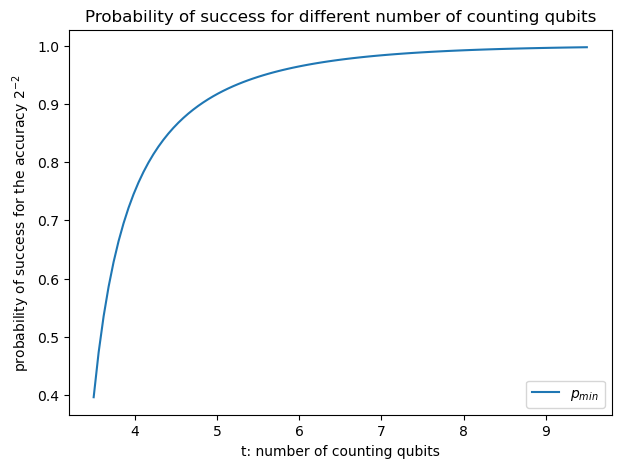

In [20]:
y = lambda t, n: 1-1/(2*(2**(t-n)-2))
t_q = np.linspace(3.5, 9.5, 100 )
p_min = y(t_q, 2)

plt.figure(figsize=(7, 5))
plt.plot(t_q, p_min, label='$p_{min}$')
plt.xlabel('t: number of counting qubits')
plt.ylabel('probability of success for the accuracy $2^{-2}$')
plt.legend(loc='lower right')
plt.title('Probability of success for different number of counting qubits')
plt.show()

<h4 style="font-size: 17px">&#128211;Step A. Construct QPE circuit to estimate $\phi$ when $\phi = 1/3$ with for the different number of counting qubits, $t$, when $t = [4, 5, 6, 7, 8, 9]$. Store all the circuits in a list variable 'circ' to simulate all the circuits at once as we did in Lab2. </h4>

In [21]:
## Your Code to create the list variable 'circ' goes here

t_list = [4,5,6,7,8,9]

phi = 1/3

angle_phi = 2*np.pi*phi

circ = []

for _t in t_list:
    circ.append(qpe(_t,angle_phi))

















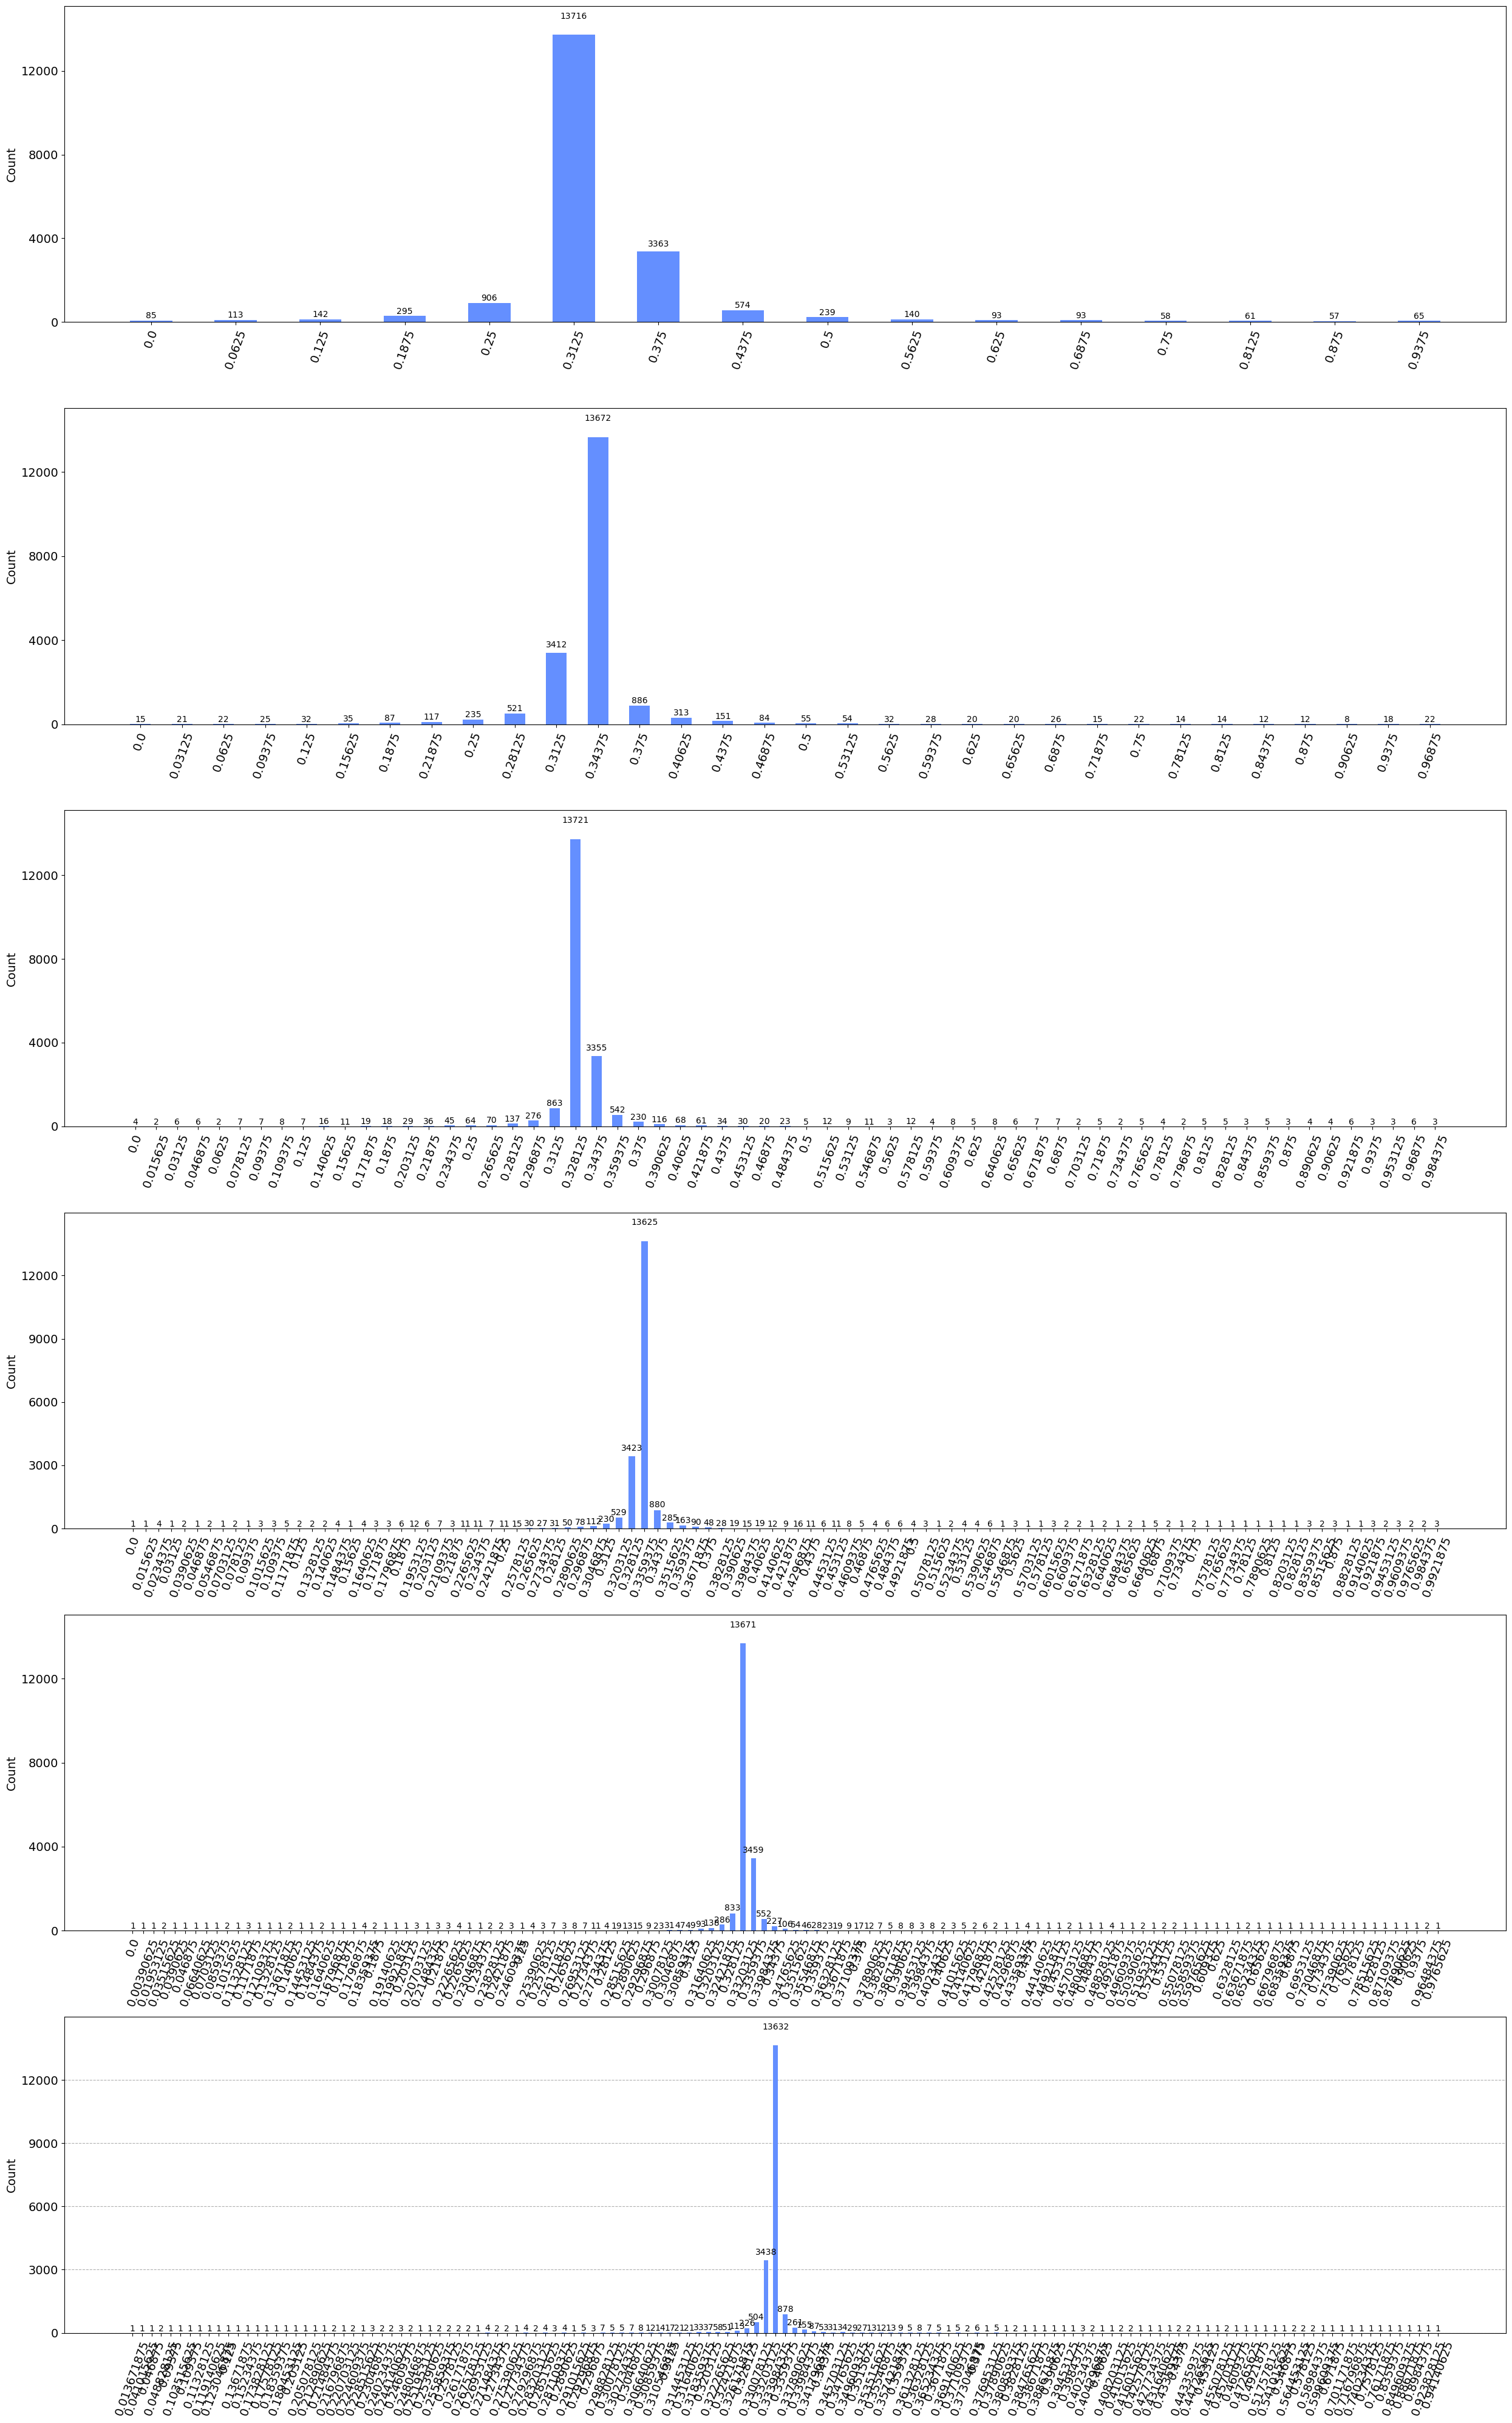

In [10]:
# Run this cell to simulate `circ` and plot the histograms of the results

results = execute(circ, sim, shots=shots).result()

n_circ = len(circ)
counts = [results.get_counts(idx) for idx in range(n_circ)]



counts_new = []
for _counts, _t in zip(counts,t_list):
    _phi_est = np.array([np.float64(int(key, 2)/2**_t) for key in list(_counts.keys())])
    _key_new = list(map(str, _phi_est))
    counts_new.append(dict(zip(_key_new, _counts.values())))

fig, ax = plt.subplots(n_circ,1,figsize=(25,40))
for idx in range(n_circ):
    plot_histogram(counts_new[idx], ax=ax[idx])
plt.tight_layout()


<h4 style="font-size: 17px">&#128211;Step B. Determine $e$, the maximum difference in integer from the best estimation for the different number of counting qubits, $t = [4, 5, 6, 7, 8, 9]$. Verify the relationship $e=2^{t-n}-1$ where $n=2$ since the desired accuracy is $2^{-2}$ in this case. </h4>

0.5625
0.125
0.5625
0.09375
0.578125
0.09375
0.578125
0.09375
0.55859375
0.0859375
0.578125
0.09375
[3, 7, 14, 28, 58, 112]


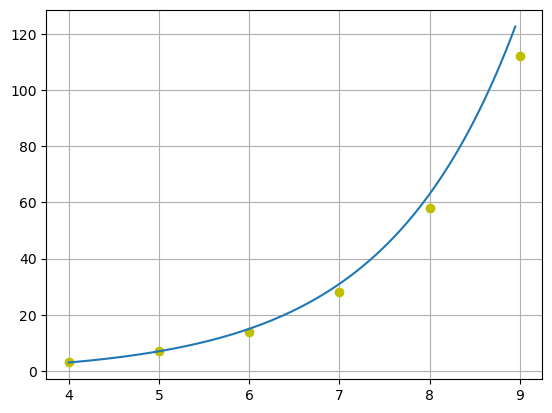

In [22]:
## Your Code goes here

e_list = []

accuracy_1_2b = 2**(-2)

for _counts,_t in zip(counts_new,t_list):
    e_list.append(calculate_e(_t, phi, accuracy_1_2b,_counts))

print(e_list)

plt.plot(t_list,e_list,'yo')

def e_relation(t):
    return ((2**(t-2)) - 1)

t_var = np.arange(min(t_list),max(t_list),(max(t_list)-min(t_list))/100)
plt.plot(t_var,e_relation(t_var))
plt.grid()













![](image/L3_prob_t.png)

<h2 style="font-size:24px;">Part 2: QPE on Noisy Quantum System</h2>

<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;">Run the QPE circuit on a real quantum system to understand the result and limitations when using noisy quantum systems</p>
</div>


The accuracy analysis that we performed in Part 1 would not be correct when the QPE circuit is executed on present day noisy quantum systems.  In part 2, we will obtain QPE results by running the circuit on a backend from IBM Quantum Experience to examine how noise affects the outcome and learn techniques to reduce its impact.   

<h4 style="font-size: 17px">Step A. Load your account and select the backend from your provider. </h4>

In [13]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
backend = provider.get_backend('ibmq_quito')
backend_sim = AerSimulator.from_backend(backend)

<h4 style="font-size: 17px">&#128211;Step B. Generate multiple ( as many as you want ) transpiled circuits of <code>qc4</code> that you set up in Part 1 at the beginning. Choose one with the minimum circuit depth, and the other with the maximum circuit depth.</h4>

Transpile the circuit with the parameter `optimization_level = 3` to reduce the error in the result.  As we learned in Lab 1, Qiskit by default uses a stochastic swap mapper to place the needed SWAP gates, which varies the transpiled circuit results even under the same runtime settings.  Therefore, to achieve shorter depth transpiled circuit for smaller error in the outcome, transpile `qc4` multiple times and choose one with the minimum circuit depth. Select the maximum circuit depth one as well for comparison purposes. 

In [14]:
## Your code goes here


depth_min = 10000
depth_max = 0
qc4_out_min = []
qc4_out_max = []
for loop_count in range(50):
    qc_trans = transpile(qc4, backend=backend_sim, optimization_level=3)
    #print(qc_trans.depth())
    if qc_trans.depth() < depth_min:
        depth_min = qc_trans.depth()
        qc4_out_min.append(qc_trans)
    if qc_trans.depth() > depth_max:
        depth_max = qc_trans.depth()
        qc4_out_max.append(qc_trans)





circuit with minimum transpiled depth of 67


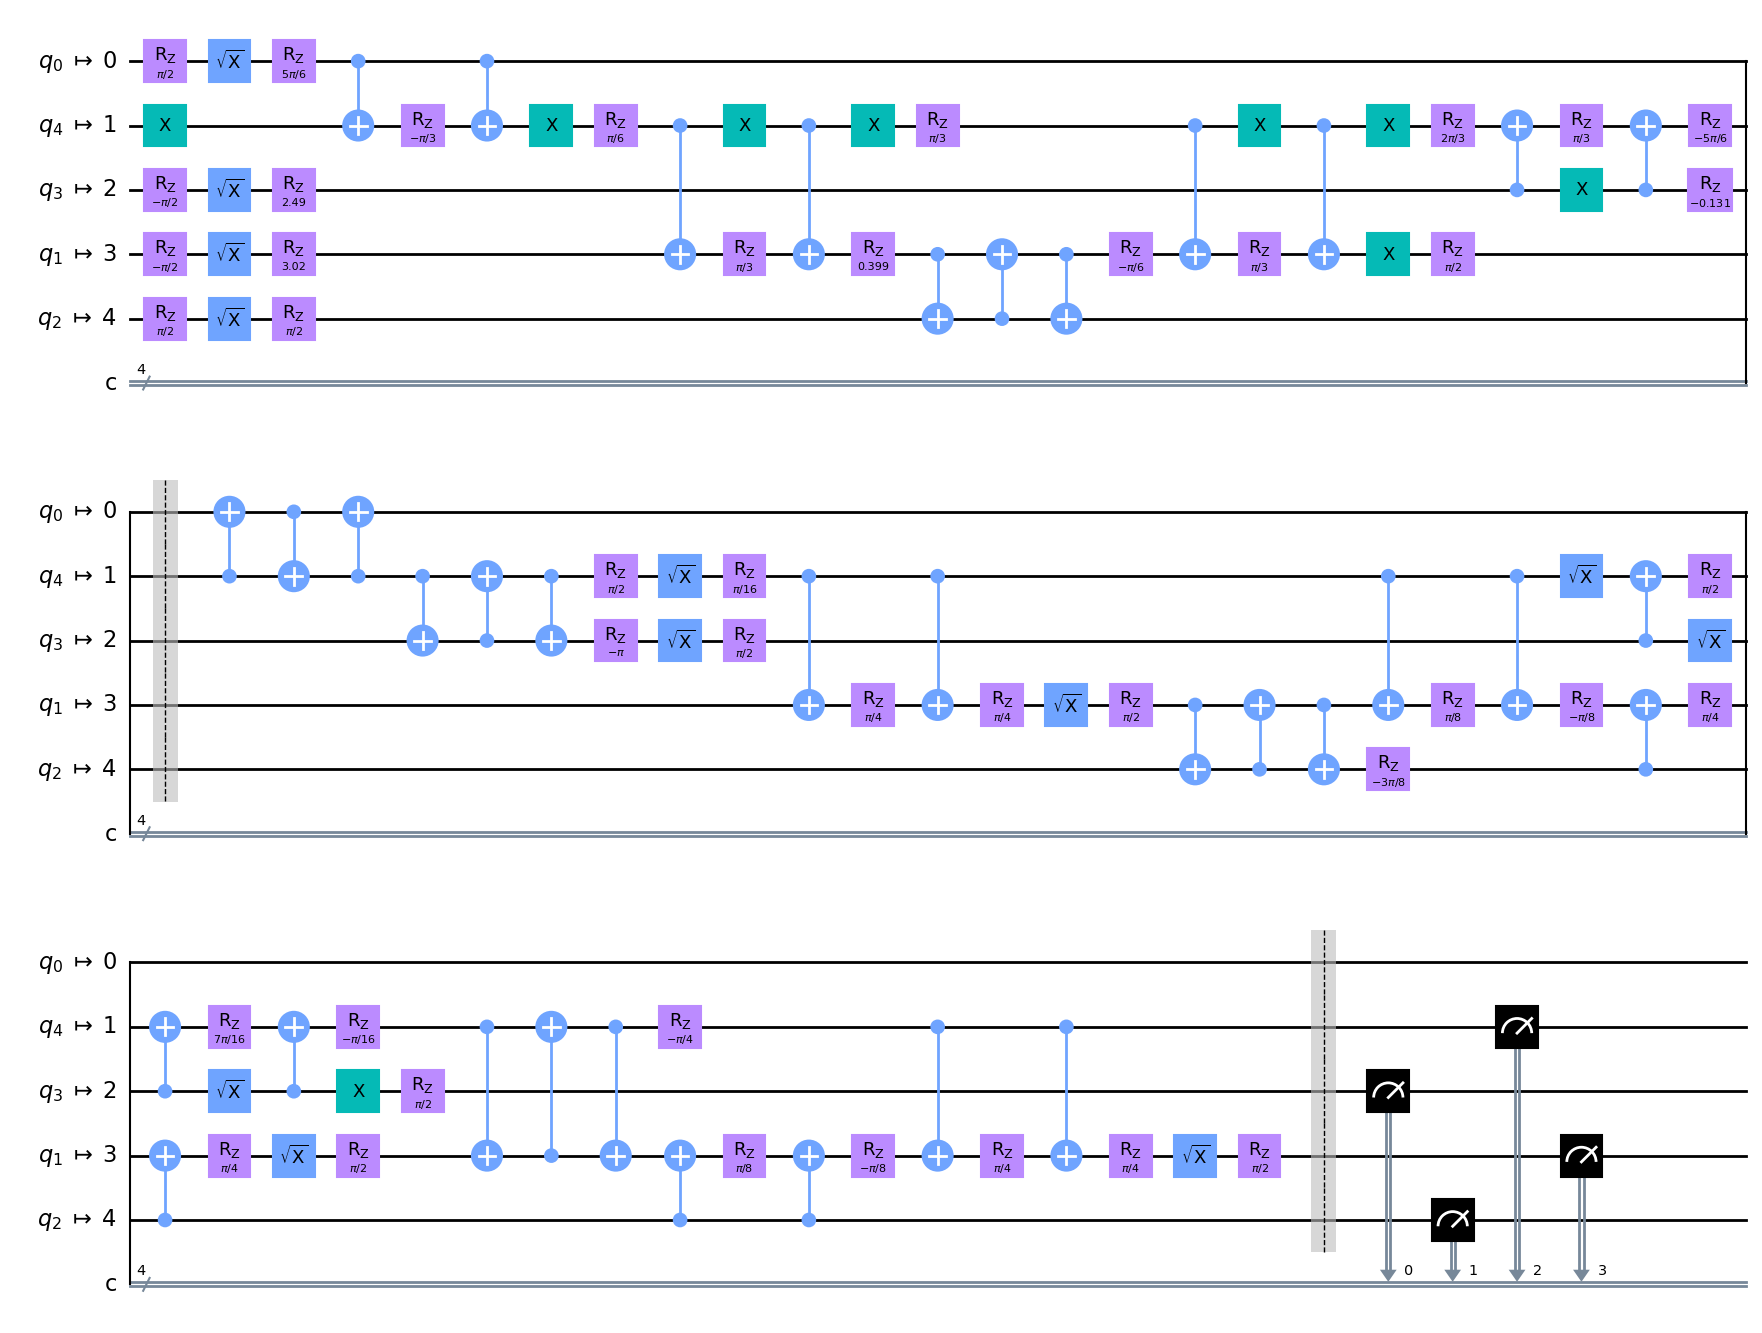

In [15]:
print("circuit with minimum transpiled depth of "+ str(qc4_out_min[-1].depth()))
qc4_out_min[-1].draw('mpl')



circuit with maximum transpiled depth of 78


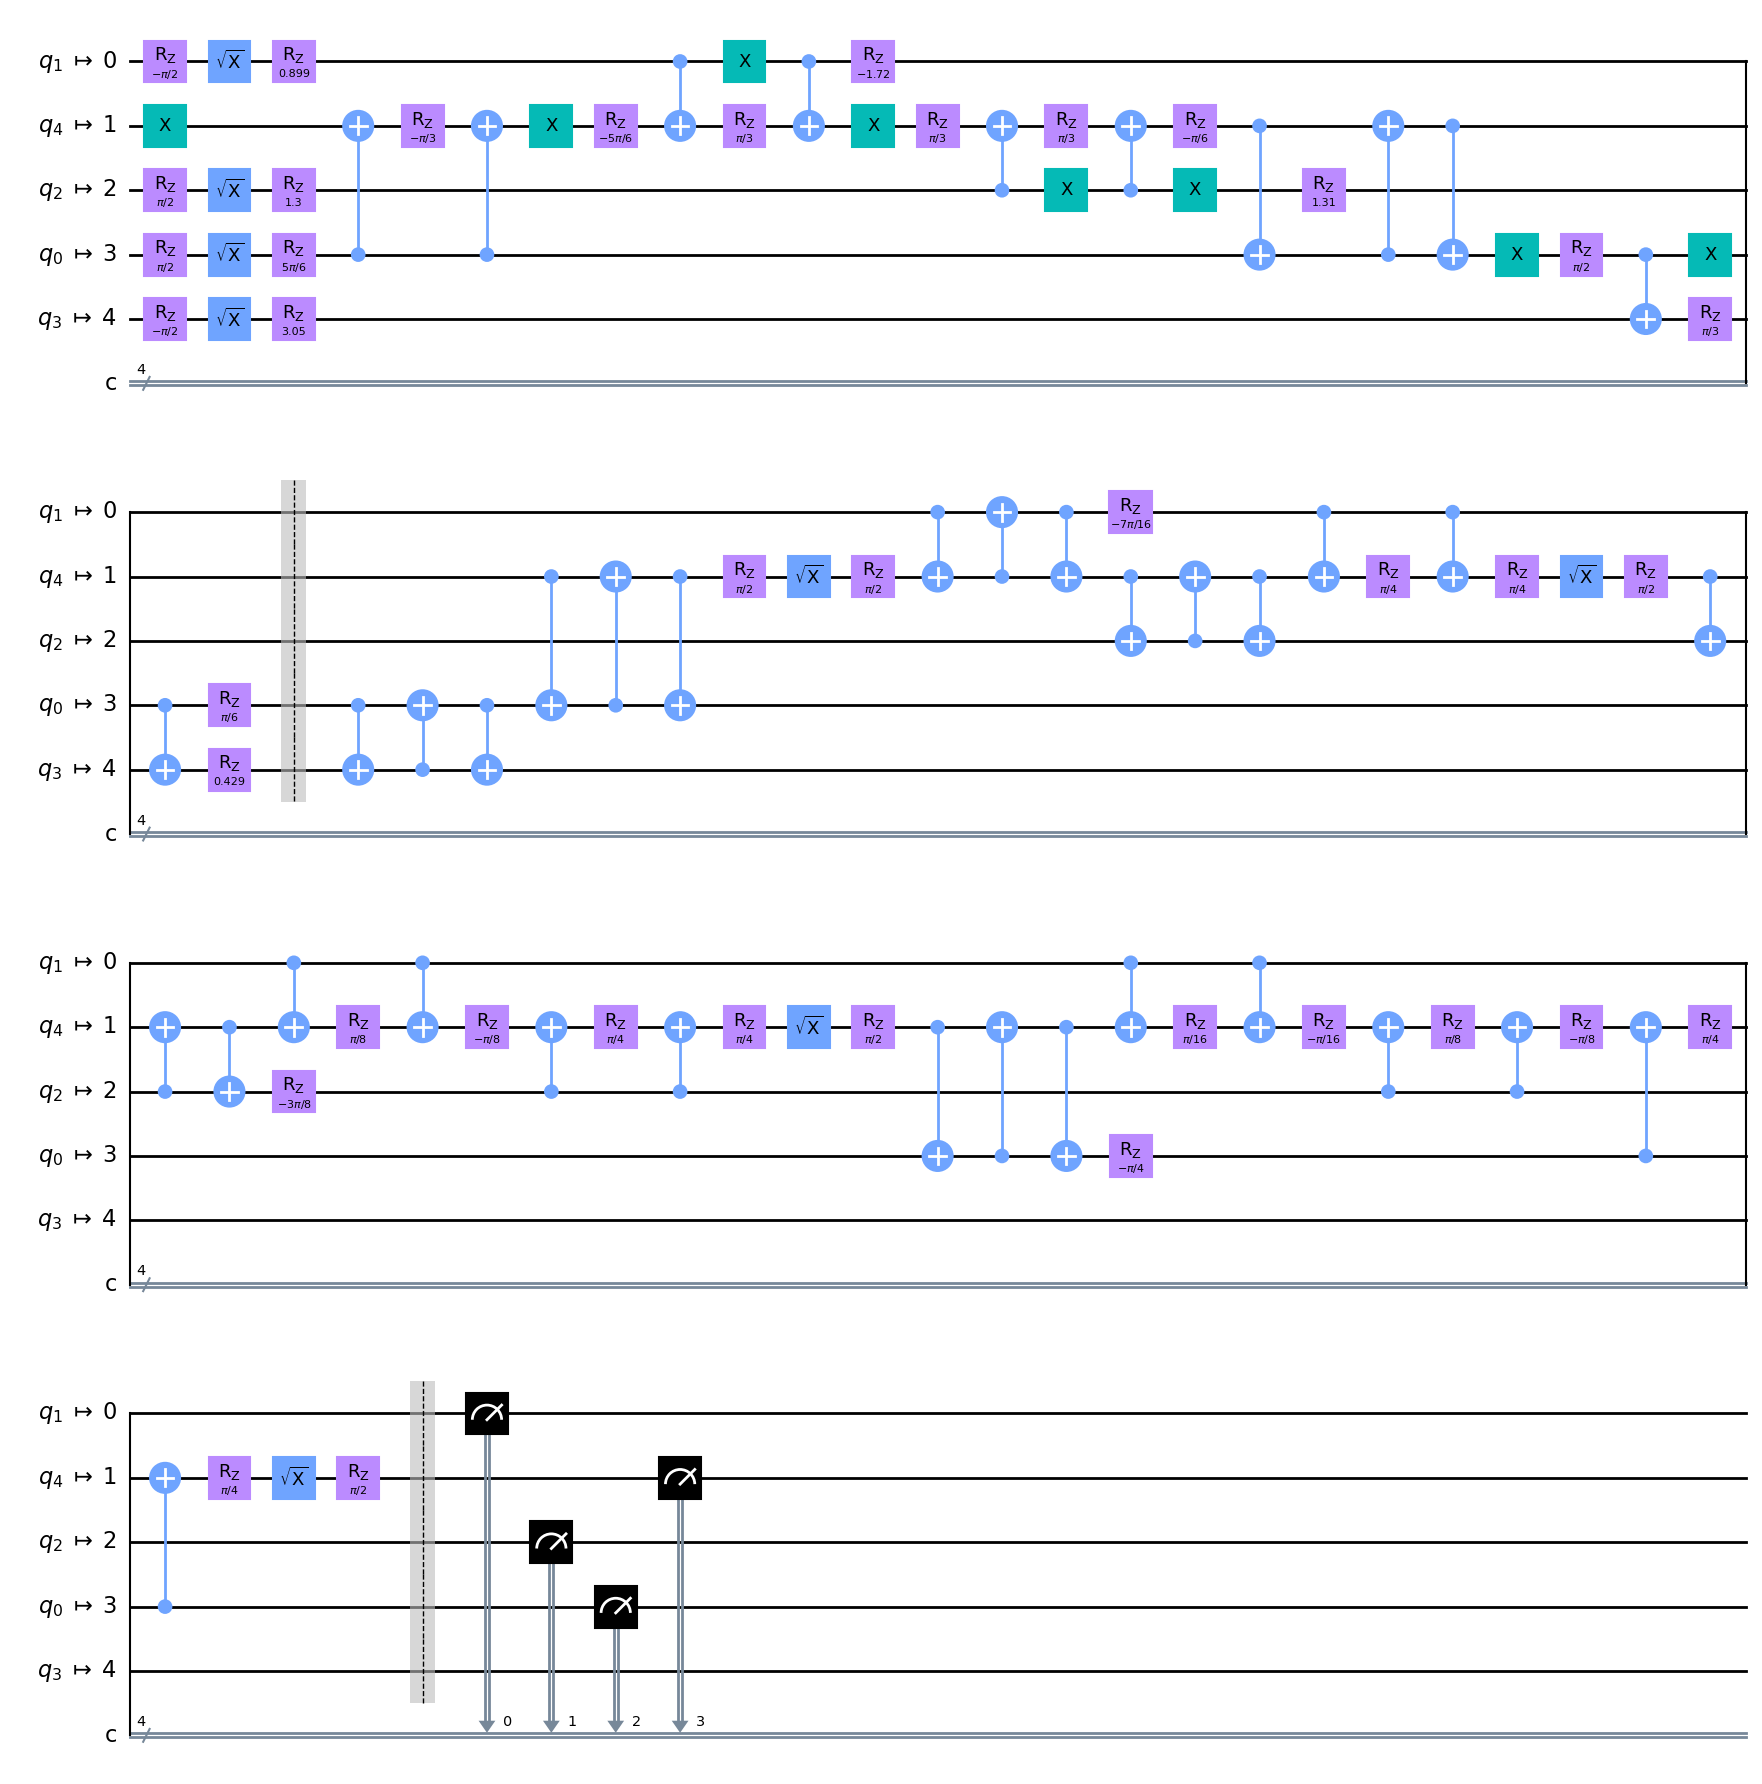

In [16]:
print("circuit with maximum transpiled depth of "+ str(qc4_out_max[-1].depth()))
qc4_out_max[-1].draw('mpl')





<h4 style="font-size: 17px">&#128211;Step C. Execute both circuits on the backend that you picked. Plot the histogram for the results and compare them with the simulation result in Part 1.</h4>

histogram for minimum depth
308808a3-6da7-48f3-b3e4-bf0ade03a37f
Job Status: job has successfully run


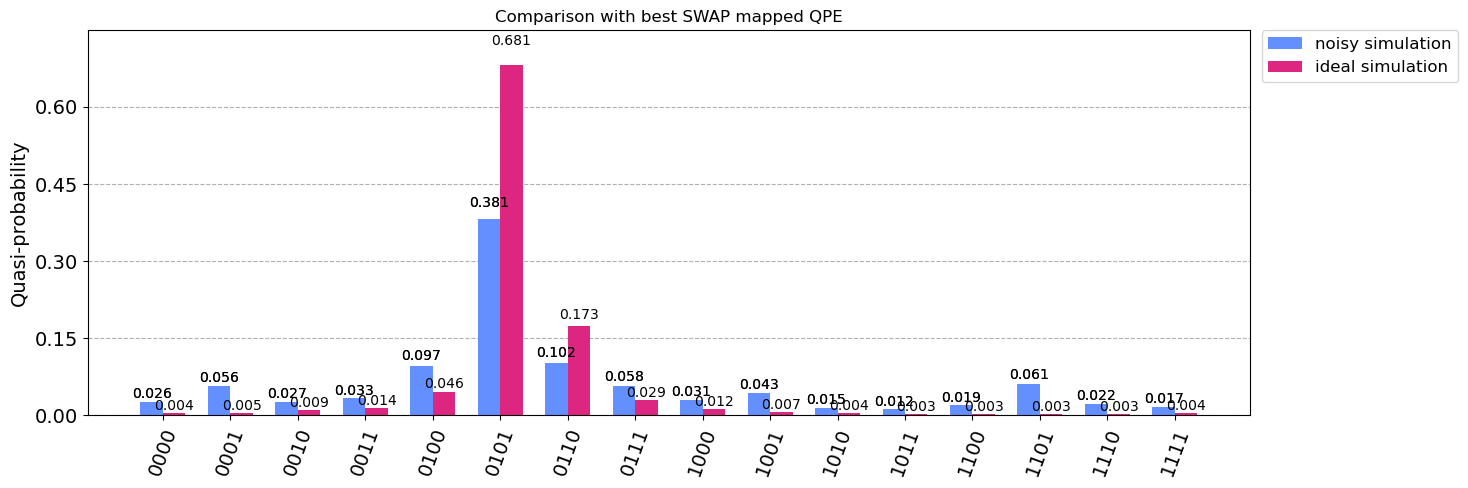

In [17]:
## Your code goes here

print("histogram for minimum depth")

job = backend_sim.run(qc4_out_min[-1], shots=8192)
print(job.job_id())
job_monitor(job)

output = job.result().get_counts()

legend = ['noisy simulation','ideal simulation']
plot_histogram([output,count_qc4], figsize=(15,5), legend= legend, title = 'Comparison with best SWAP mapped QPE')


histogram for maxmium depth
b5d8e123-90f5-4fde-baaf-77cff1c00b61
Job Status: job has successfully run


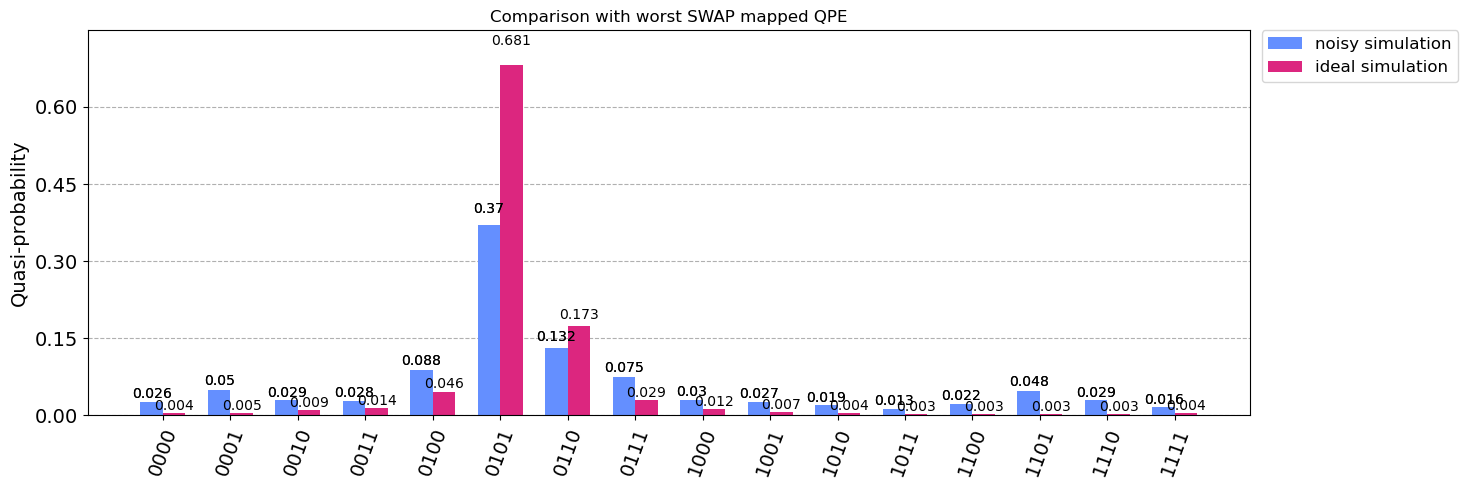

In [18]:



print("histogram for maxmium depth")
job = backend_sim.run(qc4_out_max[-1], shots=8192)
print(job.job_id())
job_monitor(job)

output = job.result().get_counts()

legend = ['noisy simulation','ideal simulation']
plot_histogram([output,count_qc4], figsize=(15,5), legend= legend, title = 'Comparison with worst SWAP mapped QPE')








# Extended Lab. for an accuracy of $2^{-3}$


![](image/L3_QPEresults.png)

<h2 style="font-size:24px;">Part 1: Performance of Quantum Phase Estimation</h2>

<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;">Investigate the relationship between the number of qubits required for the desired accuracy of the phase estimation with high probability.</p>
</div>


The accuracy of the estimated value through Quantum Phase Estimation (QPE) and its probability of success depend on the number of qubits employed in QPE circuits. Therefore, one might want to know the necessary number of qubits to achieve the targeted level of QPE performance, especially when the phase that needs to be determined cannot be decomposed in a finite bit binary expansion. 
In Part 1 of this lab, we examine the number of qubits required to accomplish the desired accuracy and the probability of success in determining the phase through QPE.

<h3 style="font-size: 20px">1. Find the probability of obtaining the estimation for a phase value accurate to $2^{-3}$ successfully with four counting qubits.</h3> 

<h4 style="font-size: 17px">&#128211;Step A. Set up the QPE circuit with four counting qubits and save the circuit to the variable 'qc4'.  Execute 'qc4' on a Aer simulator.  Plot the histogram of the result.</h4>

Check the QPE chapter in Qiskit textbook ( go to `3. Example: Getting More Precision` section [here](https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html#3.-Example:-Getting-More-Precision-) ) for the circuit.

In [23]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

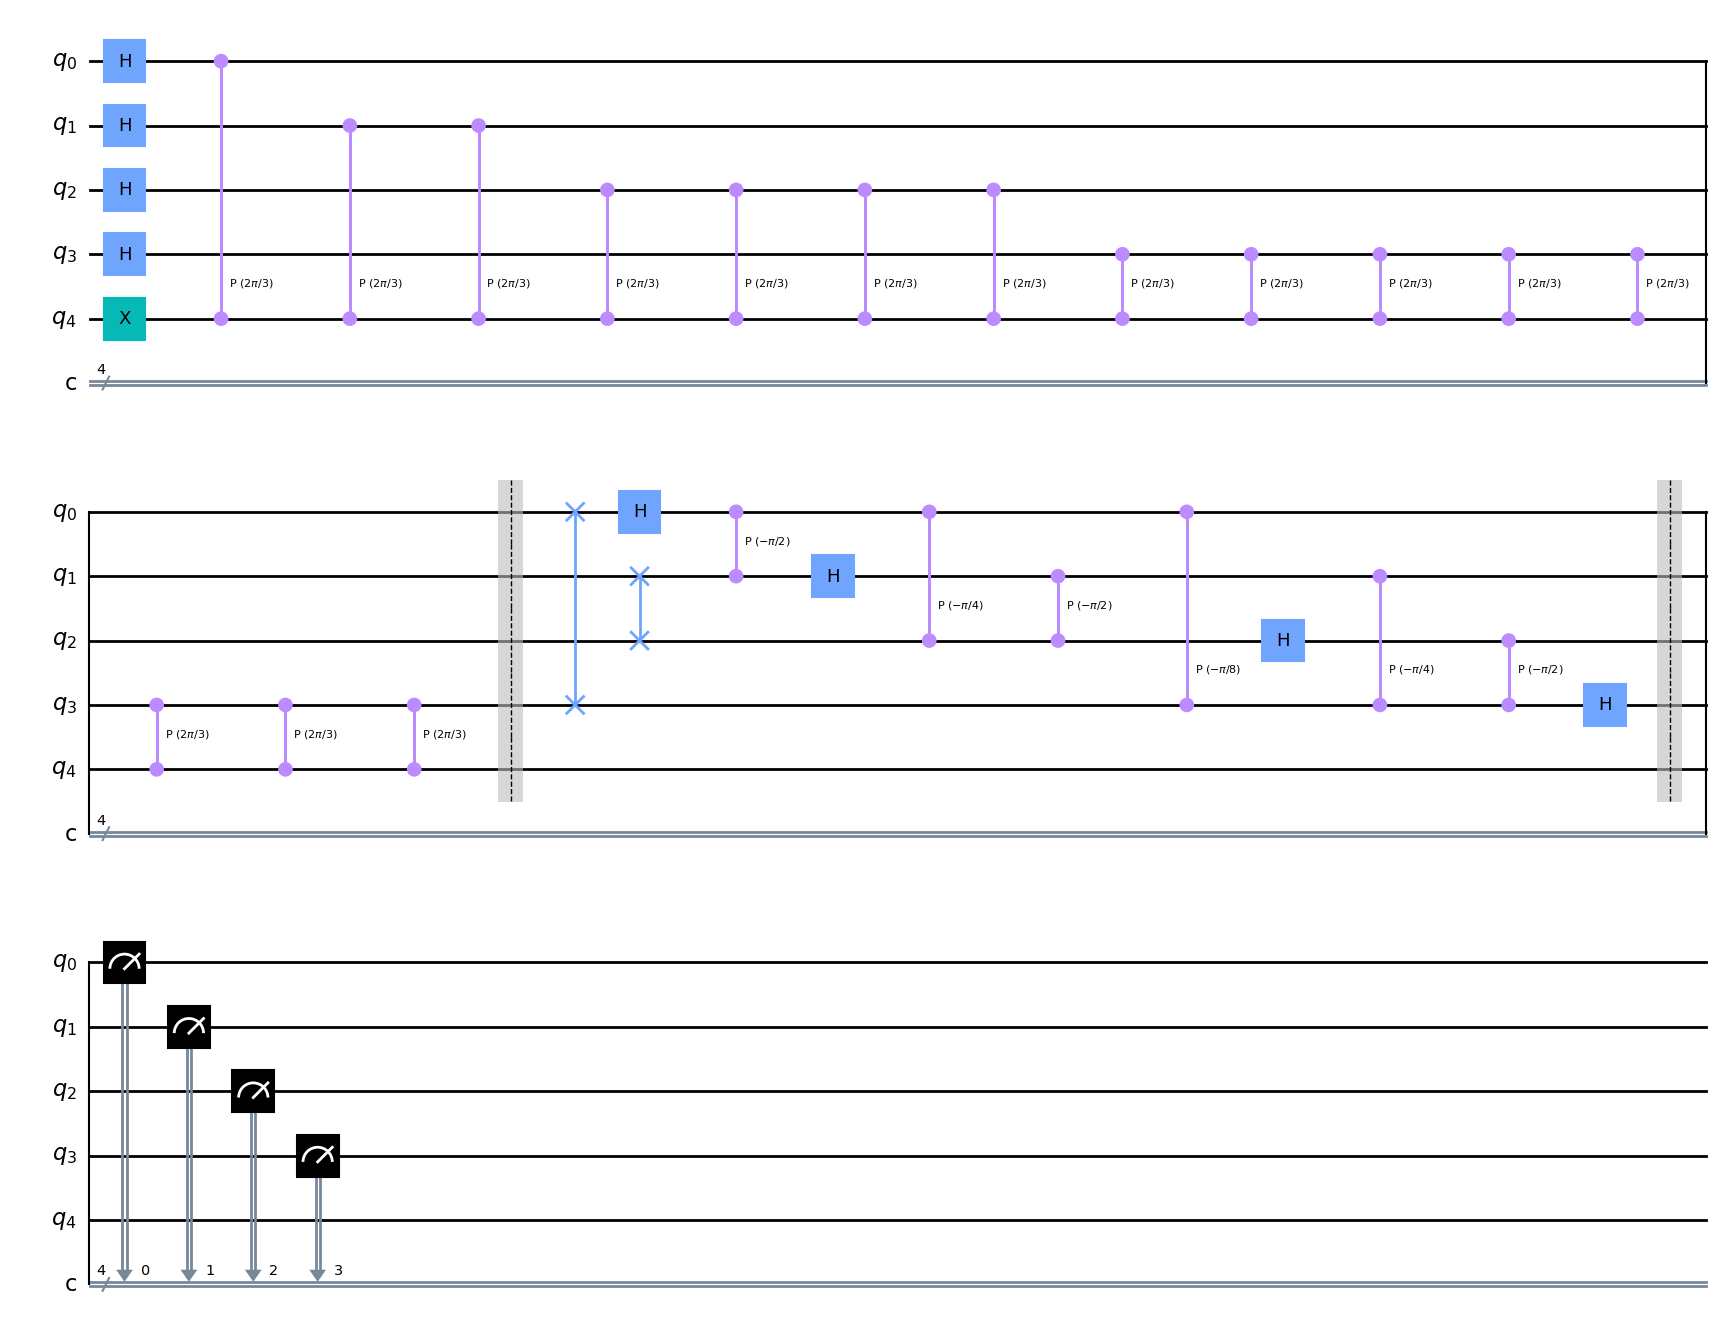

In [24]:
## Start your code to create the circuit, qc4
t = 4 # number of qubits
qc4 = QuantumCircuit(t+1,t)

#define qp rotation angle
angle = 2*np.pi/3

def qpe(no_of_qubits, theta):

    _t = no_of_qubits
    _qc = QuantumCircuit(_t+1,_t)
    #initialize |\psi> = |1> on the last qubit q_4
    _qc.x(_t)

    #apply hadmards on q_0 to q_3
    for _qubit in range(_t):
        _qc.h(_qubit)

    #apply the repeated phase shift gate
    repetitions = 1
    for counting_qubit in range(_t):
        for i in range(repetitions):
            _qc.cp(theta, counting_qubit, _t); # This is CU
        repetitions *= 2


    #define qft inverse
    def qft_dagger(qc, n):
        """n-qubit QFTdagger the first n qubits in circ"""
        # Don't forget the Swaps!
        for qubit in range(n//2):
            qc.swap(qubit, n-qubit-1)
        for j in range(n):
            for m in range(j):
                qc.cp(-np.pi/float(2**(j-m)), m, j)
            qc.h(j)

    _qc.barrier()

    qft_dagger(_qc, _t)

    _qc.barrier()
    for _qubit in range(_t):
        _cbit = _qubit
        _qc.measure(_qubit,_cbit)

    return _qc


qc4 = qpe(t, angle)


qc4.draw('mpl')

{'1101': 63, '1111': 76, '1001': 132, '0101': 13760, '1110': 56, '0100': 866, '1011': 86, '0111': 551, '0011': 331, '0010': 160, '0000': 86, '0001': 91, '0110': 3372, '1000': 215, '1100': 74, '1010': 81}
{'1101': 0.00315, '1111': 0.0038, '1001': 0.0066, '0101': 0.688, '1110': 0.0028, '0100': 0.0433, '1011': 0.0043, '0111': 0.02755, '0011': 0.01655, '0010': 0.008, '0000': 0.0043, '0001': 0.00455, '0110': 0.1686, '1000': 0.01075, '1100': 0.0037, '1010': 0.00405}


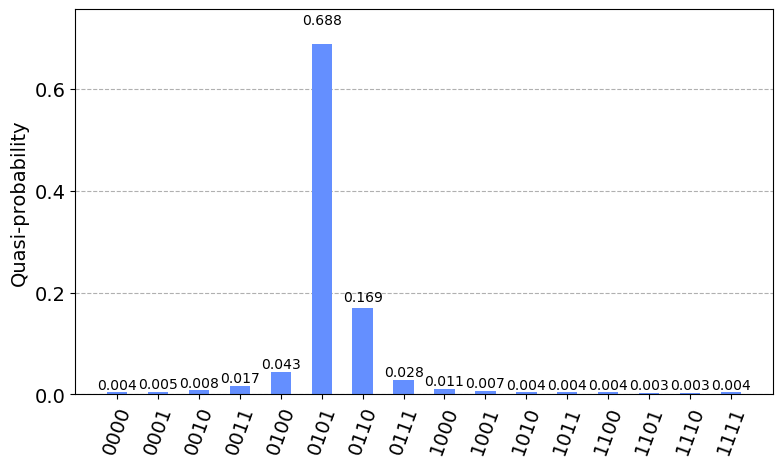

In [25]:
## Run this cell to simulate 'qc4' and to plot the histogram of the result
sim = Aer.get_backend('aer_simulator')
shots = 20000
count_qc4 = execute(qc4, sim, shots=shots).result().get_counts()
print(count_qc4)
count_qc4 = {key: count/shots for key,count in count_qc4.items()}
print(count_qc4)
plot_histogram(count_qc4, figsize=(9,5))

Having performed `Step A` successfully, you will have obtained a distribution similar to the one shown below with the highest probability at `0101` which corresponds to the estimated $\phi$ value, `0.3125`.

![](image/L3_qc4_hist.png)

Since the number of counting qubits used for the circuit is four, the best estimated value should be accurate to $\delta = 2^{-4} = 0.0625$.  However, there are multiple possible outcomes as $\theta = 1/3$ cannot be expressed in a finite number of bits, the estimation by QPE here is not always bounded by this accuracy. 

Running the following cell shows the same histogram but with all possible estimated $\phi$ values on the x-axis.

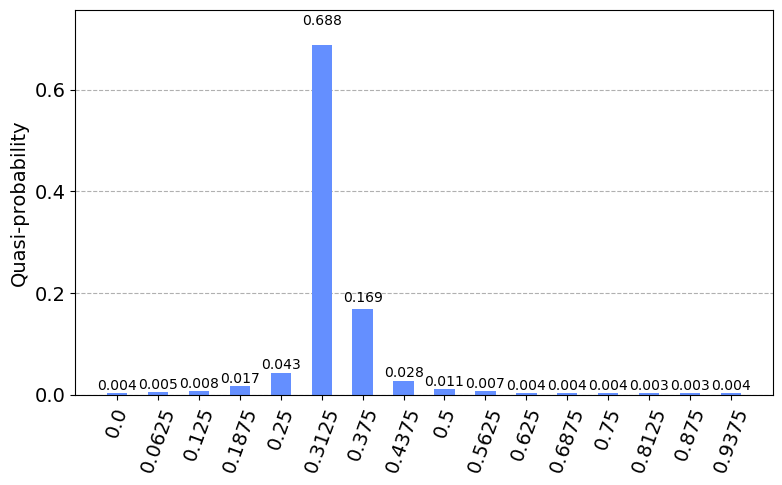

In [26]:
phi_est = np.array([round(int(key, 2)/2**t,5) for key in list(count_qc4.keys())])
key_new = list(map(str, phi_est))
count_new = dict(zip(key_new, count_qc4.values()))
plot_histogram(count_new, figsize=(9,5))

**Suppose the outcome of the final measurement is $m$, and let $b$ the best estimation which is `0.3125` for this case.**
<h4 style="font-size: 17px">&#128211;Step B. Find $e$, the maximum difference in integer from the best estimation <code>0101</code> so that all the outcomes, 'm's, would approximate $\phi$ to an accuracy $2^{-2}$ when $|m - b| \leq \frac{e}{2^{t}}$. </h4>

In this case, the values of $t$ and $b$ are $4$ and $0.3125$, respectively.

For example, under $e = 1$, the considered outcomes are `0100`, `0101`, `0110` which correspond to the values of $m$: $0.25,~0.312,~0.375$, respectively, and all of them approximate the value $\frac{1}{3}$ to an accuracy $2^{-2}$.

In [27]:
## Your code goes here
b = [np.float64(key) for key, value in count_new.items() if value == max(count_new.values())][0]

theta = angle/(2*np.pi)

n = 3
accuracy = 2**(-1*n)

def calculate_e(_t,_theta,_accuracy,_count_dict):
    m_max = 0
    m_min = np.float64(999)

    for key, val in _count_dict.items():
        m = np.float64(key)
        if m > m_max and np.abs(m - _theta) <= _accuracy:
            m_max = m
        if m < m_min and np.abs(m - _theta) <= _accuracy:
            m_min = m
    print(m_max)
    print(m_min)

    e_max = np.int64(np.ceil(min({np.abs(m_max-b),np.abs(m_min-b)})*(2**_t)))
    return e_max

e_max = calculate_e(t,theta,accuracy,count_new)

print("e should be greater than equal to " + str(e_max))


    










0.4375
0.25
e should be greater than equal to 1


<h4 style="font-size: 17px">&#128211;Step C. Compute the probability of obtaining an approximation correct to an accuracy $2^{-2}$.  Verify that the computed probability value is larger or equal to $1- \frac{1}{2(2^{(t-n)}-2)}$ where $t$ is the number of counting bits and the $2^{-n}$ is the desired accuracy. </h4>

Now it is easy to evaluate the probability of the success from the histogram since all the outcomes that approximate $\phi$ to the accuracy $2^{-2}$ can be found based on the maximum difference $e$ from the best estimate. 

In [29]:
## Your code goes here

compund_probability = 0
#print(count_new)
for key, val in count_new.items():
    m = np.float64(key)
    if np.abs(m - b)*(2**t) <= e_max:
        #print(val)
        compund_probability = compund_probability + val

#expected_val = 1 - (1/(2*((2**(t-n)) - 2)))

print("the probability of approximately corrrect answer within the accuracy " + str(accuracy) + " is " + str(compund_probability) )












the probability of approximately corrrect answer within the accuracy 0.125 is 0.8998999999999999


<h3 style="font-size: 20px">2. Compute the probability of success for the accuracy $2^{-2}$ when the number of counting qubits, $t$, varies from four to nine. Compare your result with the equation $t=n+log(2+\frac{1}{2\epsilon})$ when $2^{-n}$ is the desired accuracy and $\epsilon$ is 1 - probability  of success.</h3> 

The following plot shows the relationship between the number of counting qubit, t, and the minimum probability of success to approximate the phase to an accuracy $2^{-2}$.  Check the Ch. 5.2.1 Performance and requirements in `[QCQI]`.

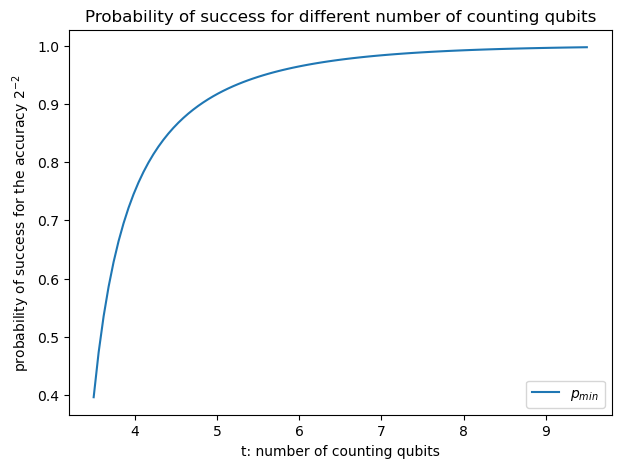

In [30]:
y = lambda t, n: 1-1/(2*(2**(t-n)-2))
t_q = np.linspace(3.5, 9.5, 100 )
p_min = y(t_q, 2)

plt.figure(figsize=(7, 5))
plt.plot(t_q, p_min, label='$p_{min}$')
plt.xlabel('t: number of counting qubits')
plt.ylabel('probability of success for the accuracy $2^{-2}$')
plt.legend(loc='lower right')
plt.title('Probability of success for different number of counting qubits')
plt.show()

<h4 style="font-size: 17px">&#128211;Step A. Construct QPE circuit to estimate $\phi$ when $\phi = 1/3$ with for the different number of counting qubits, $t$, when $t = [4, 5, 6, 7, 8, 9]$. Store all the circuits in a list variable 'circ' to simulate all the circuits at once as we did in Lab2. </h4>

In [31]:
## Your Code to create the list variable 'circ' goes here

t_list = [4,5,6,7,8,9]

phi = 1/3

angle_phi = 2*np.pi*phi

circ = []

for _t in t_list:
    circ.append(qpe(_t,angle_phi))

















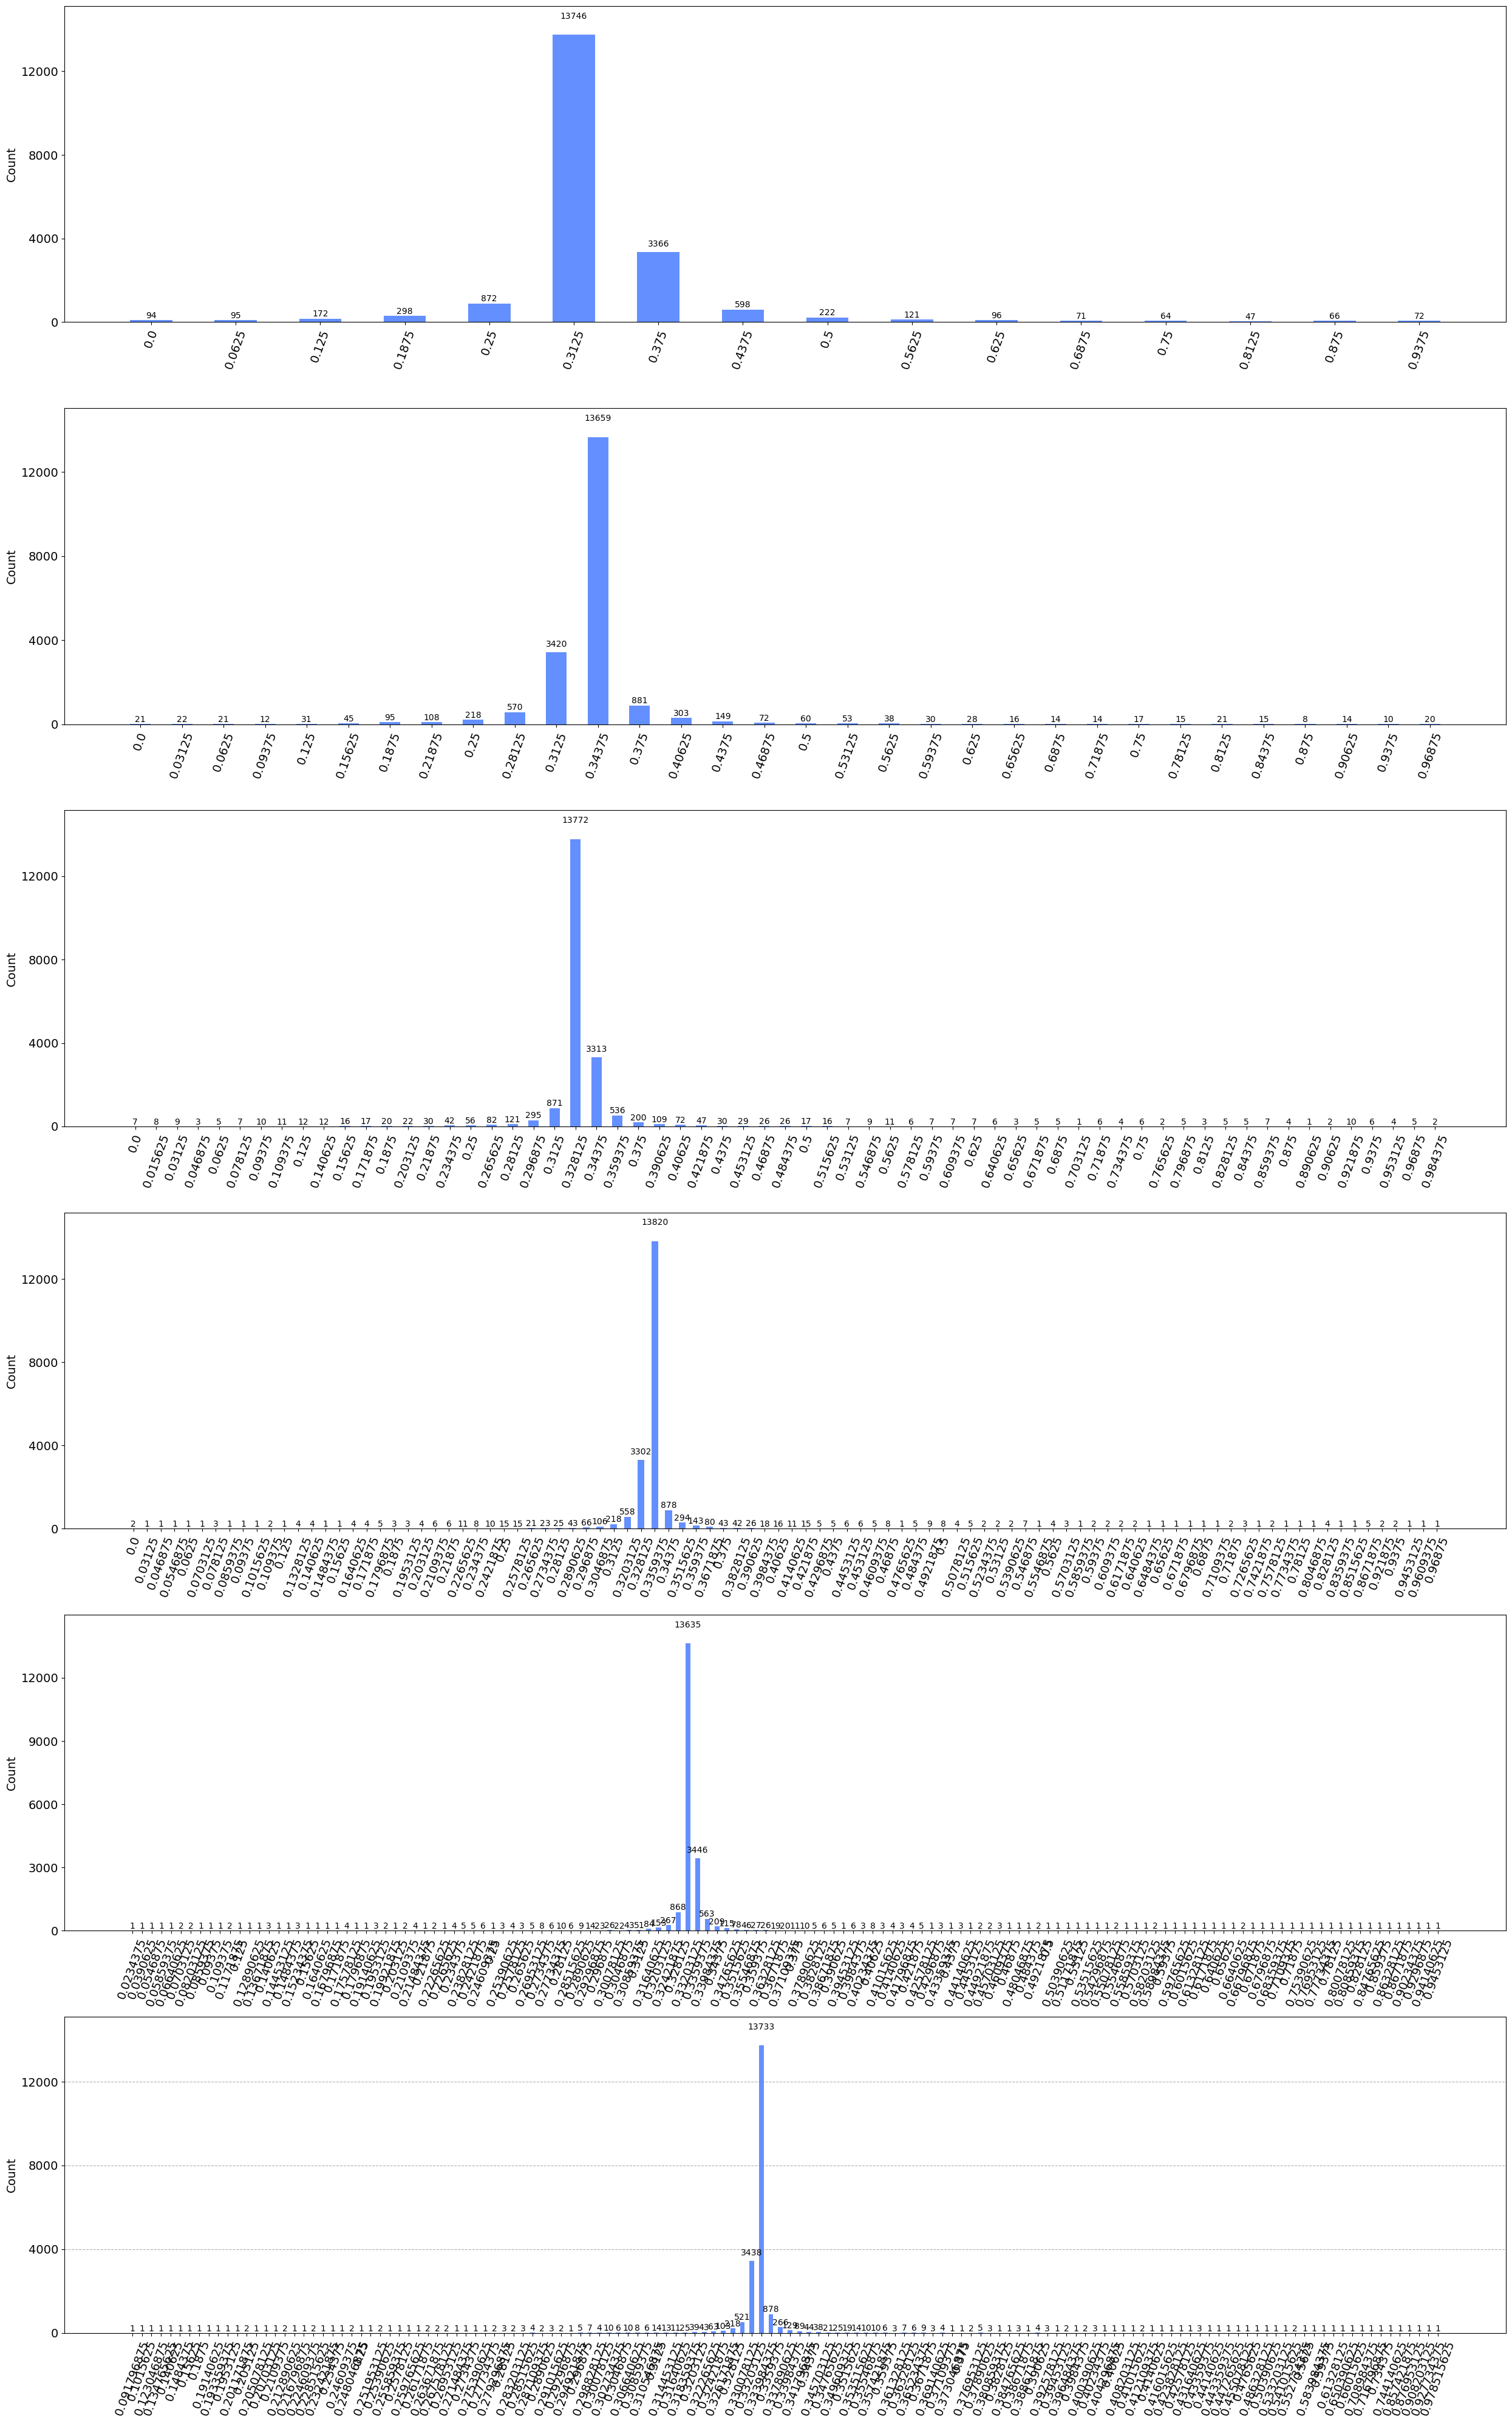

In [32]:
# Run this cell to simulate `circ` and plot the histograms of the results

results = execute(circ, sim, shots=shots).result()

n_circ = len(circ)
counts = [results.get_counts(idx) for idx in range(n_circ)]



counts_new = []
for _counts, _t in zip(counts,t_list):
    _phi_est = np.array([np.float64(int(key, 2)/2**_t) for key in list(_counts.keys())])
    _key_new = list(map(str, _phi_est))
    counts_new.append(dict(zip(_key_new, _counts.values())))

fig, ax = plt.subplots(n_circ,1,figsize=(25,40))
for idx in range(n_circ):
    plot_histogram(counts_new[idx], ax=ax[idx])
plt.tight_layout()


<h4 style="font-size: 17px">&#128211;Step B. Determine $e$, the maximum difference in integer from the best estimation for the different number of counting qubits, $t = [4, 5, 6, 7, 8, 9]$. Verify the relationship $e=2^{t-n}-1$ where $n=2$ since the desired accuracy is $2^{-2}$ in this case. </h4>

0.4375
0.25
0.4375
0.21875
0.453125
0.21875
0.453125
0.2109375
0.45703125
0.2109375
0.455078125
0.2109375
[1, 3, 6, 13, 26, 52]


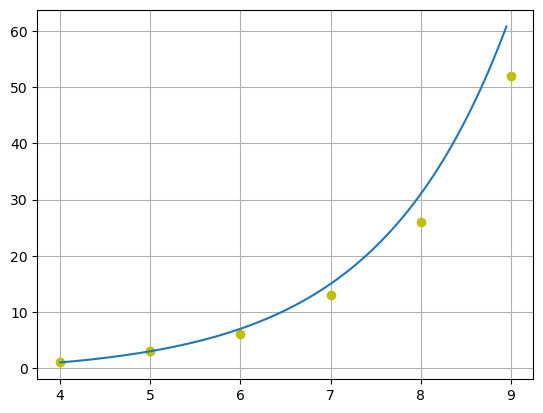

In [34]:
## Your Code goes here

e_list = []

accuracy_1_2b = 2**(-1*n)

for _counts,_t in zip(counts_new,t_list):
    e_list.append(calculate_e(_t, phi, accuracy_1_2b,_counts))

print(e_list)

plt.plot(t_list,e_list,'yo')

def e_relation(t):
    return ((2**(t-n)) - 1)

t_var = np.arange(min(t_list),max(t_list),(max(t_list)-min(t_list))/100)
plt.plot(t_var,e_relation(t_var))
plt.grid()













![](image/L3_prob_t.png)

<h2 style="font-size:24px;">Part 2: QPE on Noisy Quantum System</h2>

<br>
<div style="background: #E8E7EB; border-radius: 5px;
-moz-border-radius: 5px;">
  <p style="background: #800080;
            border-radius: 5px 5px 0px 0px;
            padding: 10px 0px 10px 10px;
            font-size:18px;
            color:white;
            "><b>Goal</b></p>
    <p style=" padding: 0px 0px 10px 10px;
              font-size:16px;">Run the QPE circuit on a real quantum system to understand the result and limitations when using noisy quantum systems</p>
</div>


The accuracy analysis that we performed in Part 1 would not be correct when the QPE circuit is executed on present day noisy quantum systems.  In part 2, we will obtain QPE results by running the circuit on a backend from IBM Quantum Experience to examine how noise affects the outcome and learn techniques to reduce its impact.   

<h4 style="font-size: 17px">Step A. Load your account and select the backend from your provider. </h4>

In [35]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
backend = provider.get_backend('ibmq_quito')
backend_sim = AerSimulator.from_backend(backend)

ibmqfactory.load_account:WARNING:2022-11-14 04:20:13,787: Credentials are already in use. The existing account in the session will be replaced.


<h4 style="font-size: 17px">&#128211;Step B. Generate multiple ( as many as you want ) transpiled circuits of <code>qc4</code> that you set up in Part 1 at the beginning. Choose one with the minimum circuit depth, and the other with the maximum circuit depth.</h4>

Transpile the circuit with the parameter `optimization_level = 3` to reduce the error in the result.  As we learned in Lab 1, Qiskit by default uses a stochastic swap mapper to place the needed SWAP gates, which varies the transpiled circuit results even under the same runtime settings.  Therefore, to achieve shorter depth transpiled circuit for smaller error in the outcome, transpile `qc4` multiple times and choose one with the minimum circuit depth. Select the maximum circuit depth one as well for comparison purposes. 

In [36]:
## Your code goes here


depth_min = 10000
depth_max = 0
qc4_out_min = []
qc4_out_max = []
for loop_count in range(50):
    qc_trans = transpile(qc4, backend=backend_sim, optimization_level=3)
    #print(qc_trans.depth())
    if qc_trans.depth() < depth_min:
        depth_min = qc_trans.depth()
        qc4_out_min.append(qc_trans)
    if qc_trans.depth() > depth_max:
        depth_max = qc_trans.depth()
        qc4_out_max.append(qc_trans)





circuit with minimum transpiled depth of 67


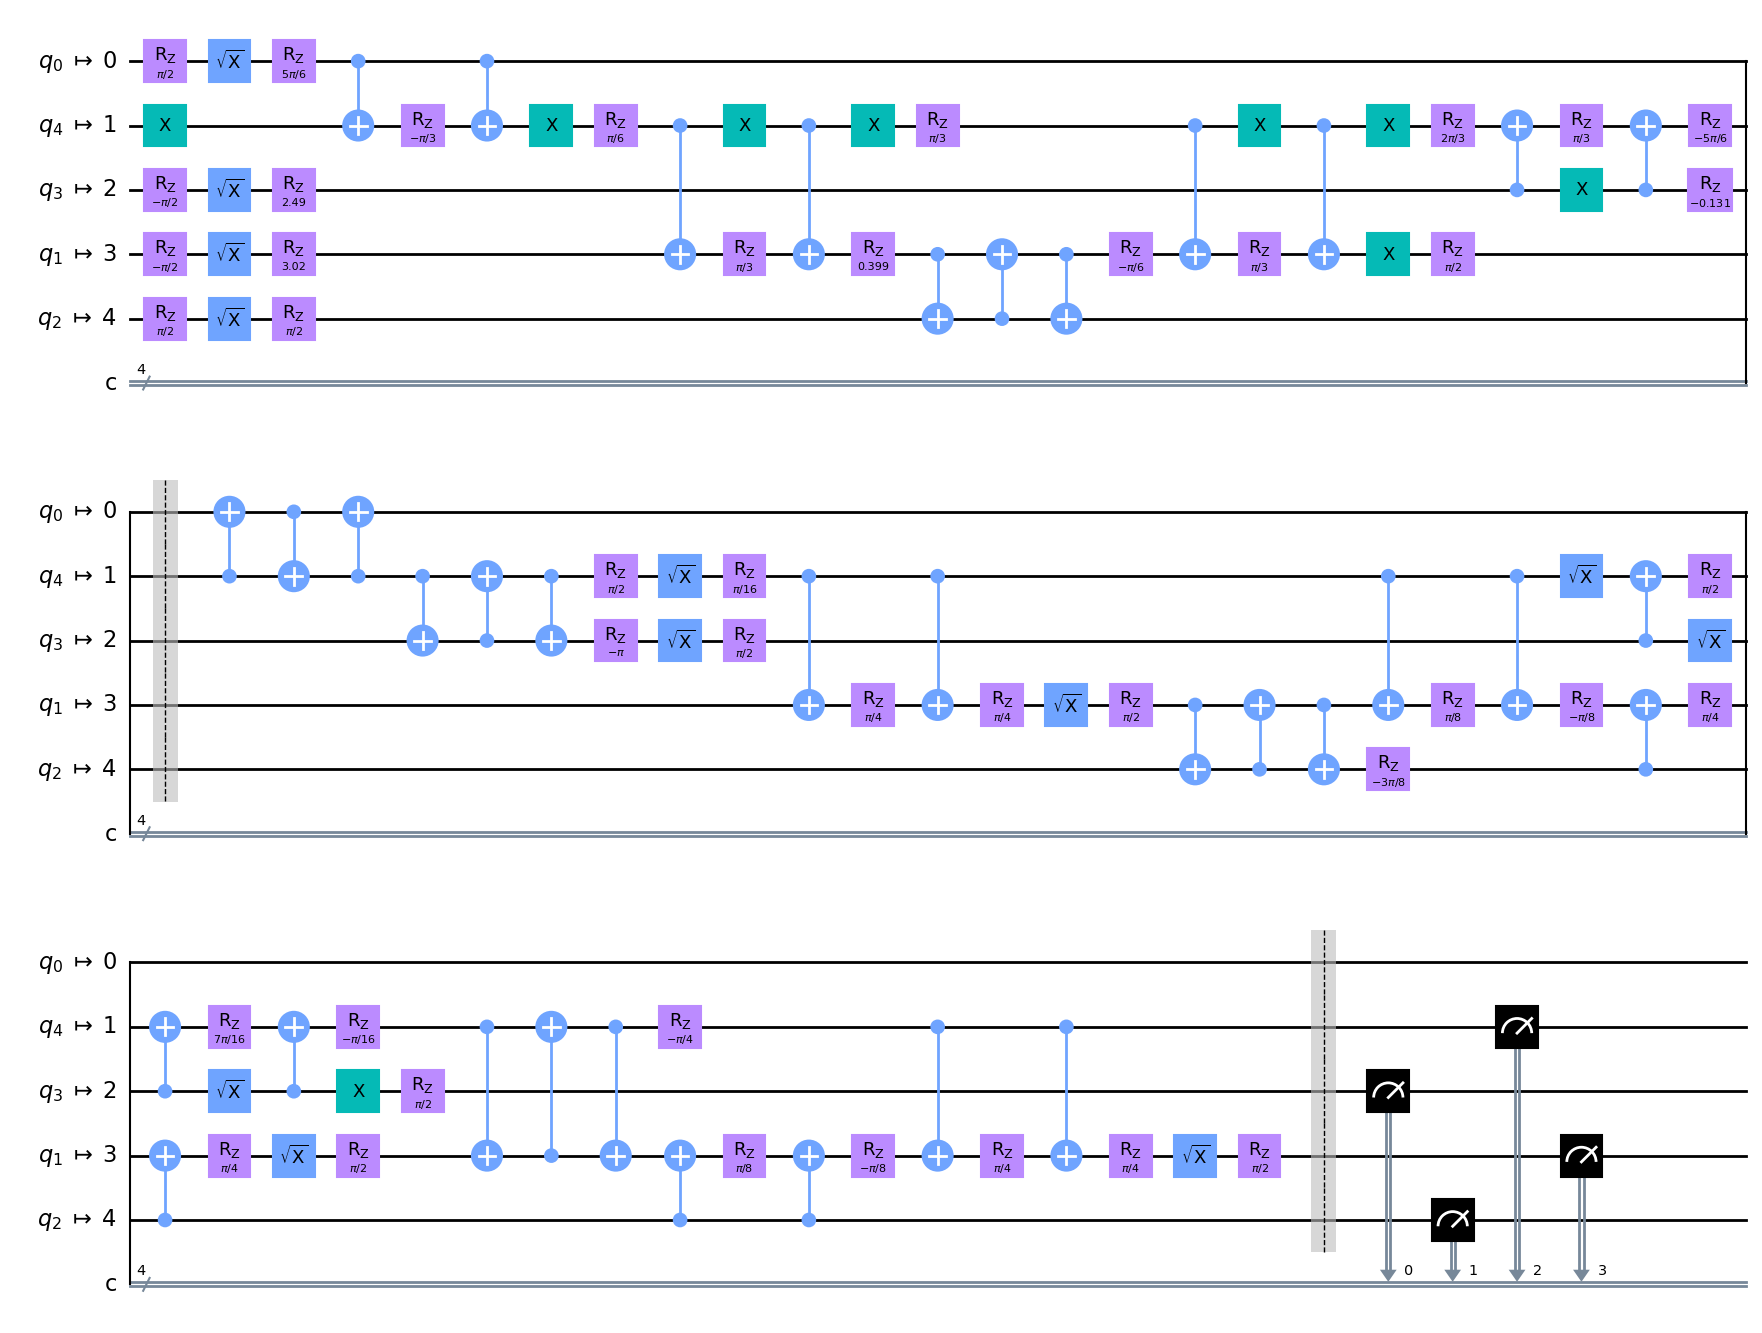

In [37]:
print("circuit with minimum transpiled depth of "+ str(qc4_out_min[-1].depth()))
qc4_out_min[-1].draw('mpl')



circuit with maximum transpiled depth of 78


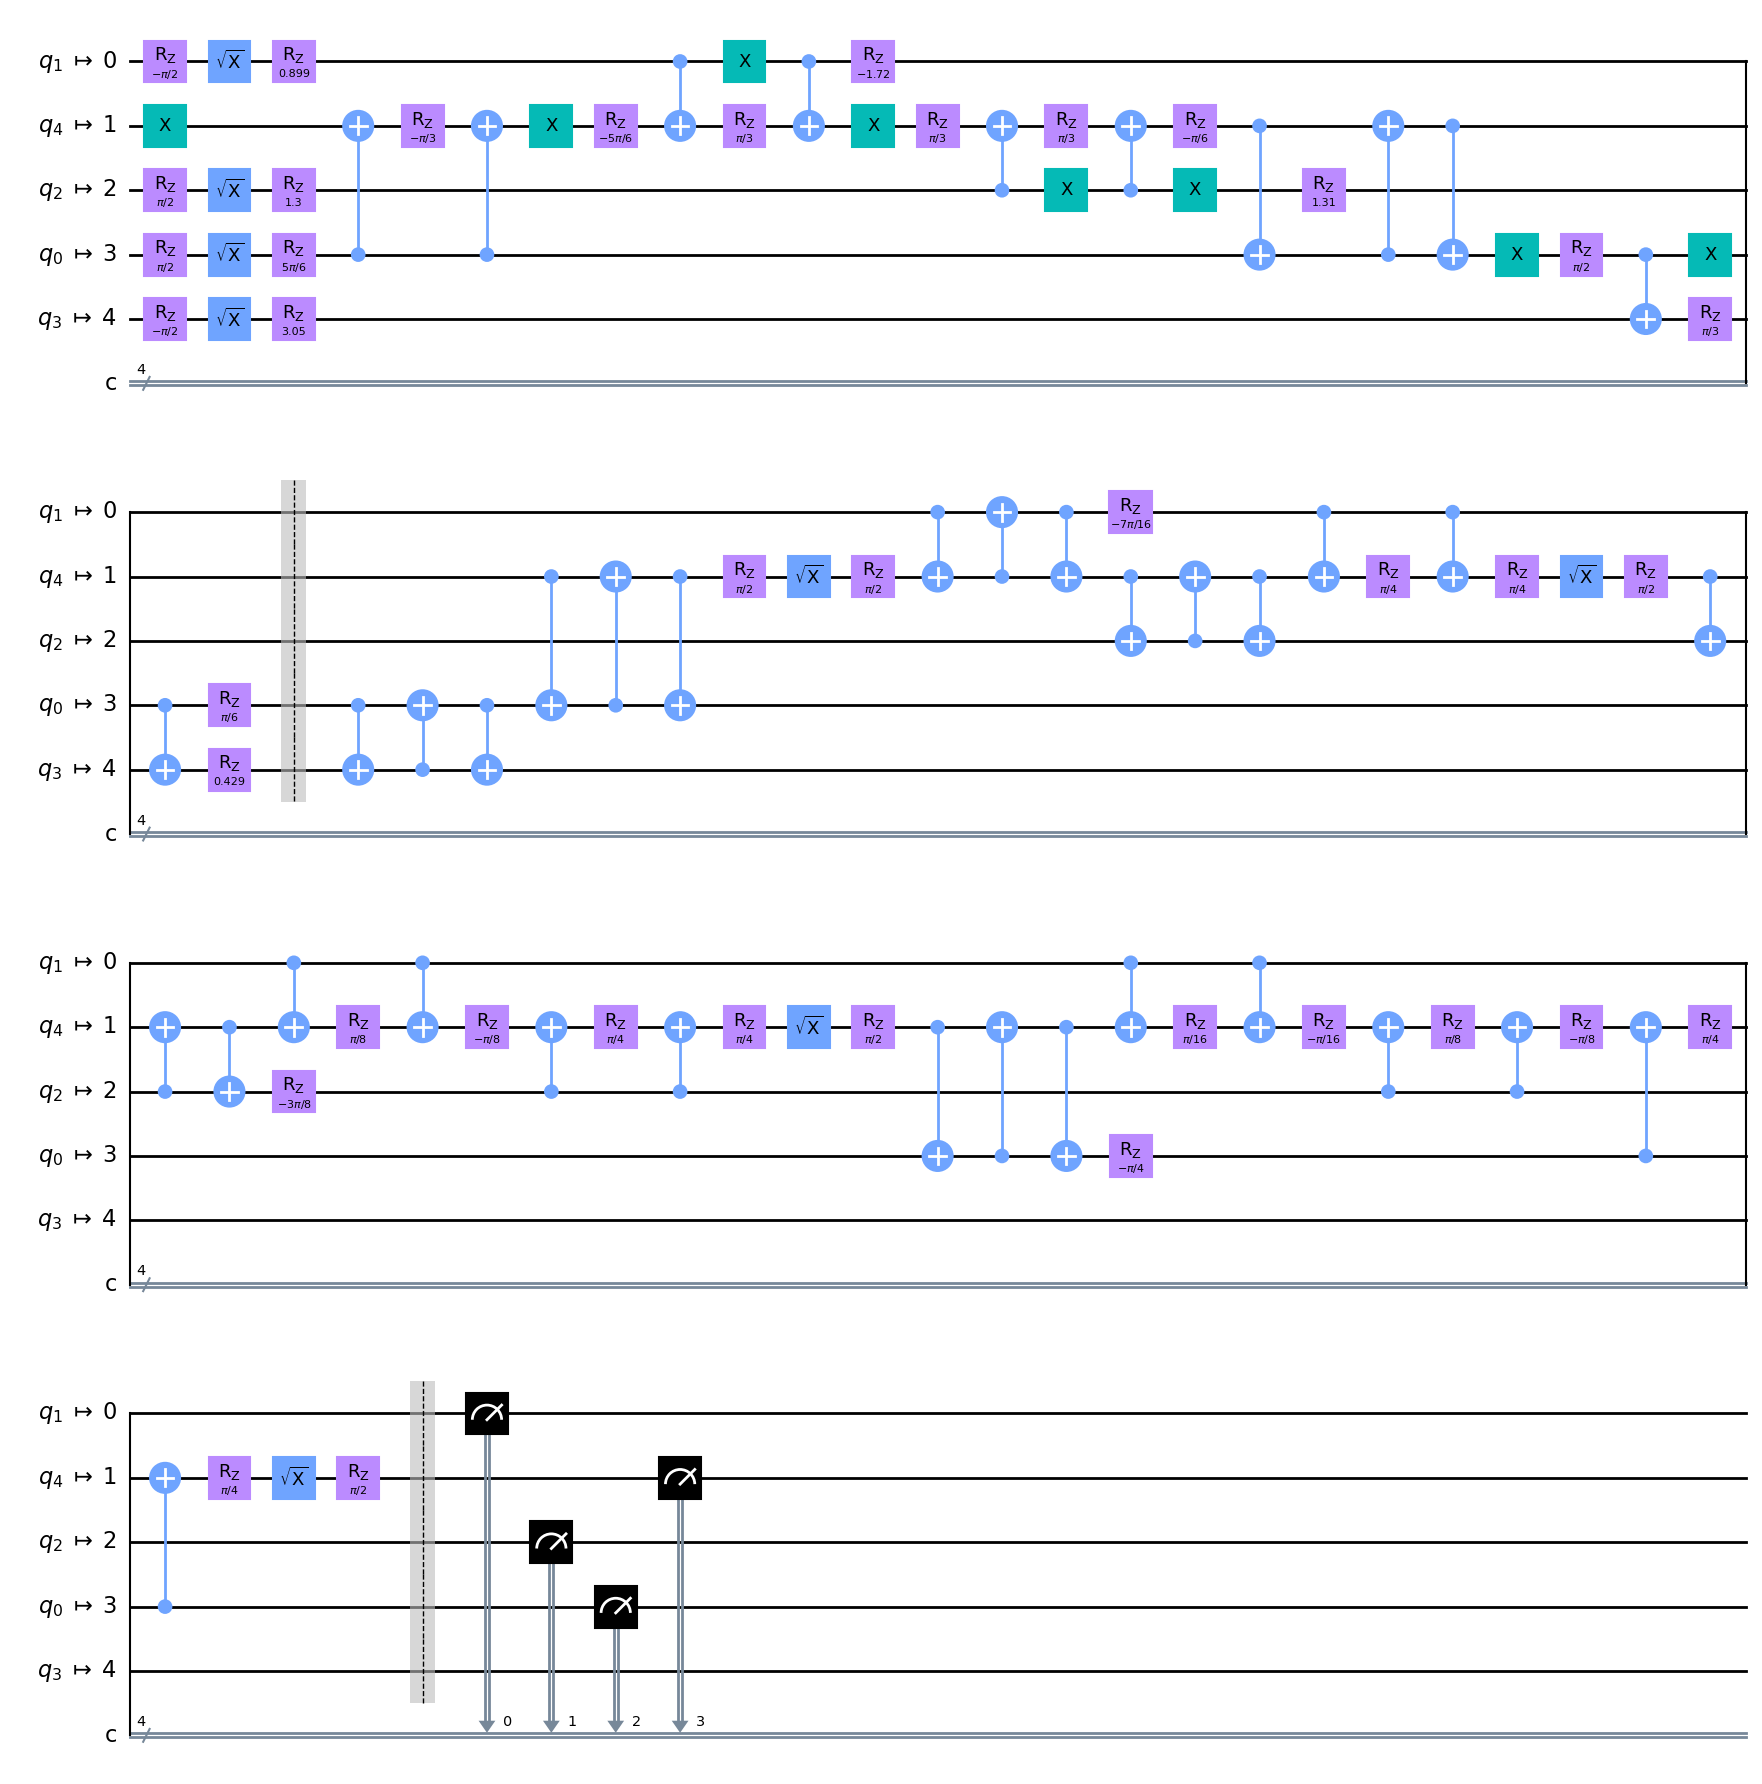

In [38]:
print("circuit with maximum transpiled depth of "+ str(qc4_out_max[-1].depth()))
qc4_out_max[-1].draw('mpl')





<h4 style="font-size: 17px">&#128211;Step C. Execute both circuits on the backend that you picked. Plot the histogram for the results and compare them with the simulation result in Part 1.</h4>

histogram for minimum depth
bdc42f42-1152-46fb-86e3-c7a4ae0890a5
Job Status: job has successfully run


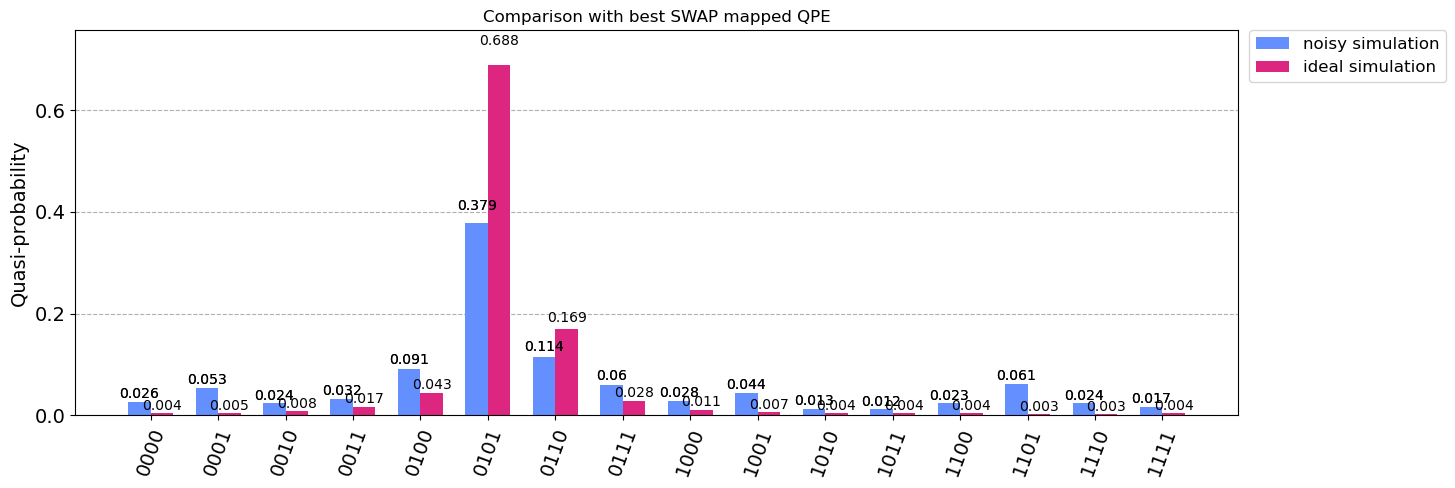

In [39]:
## Your code goes here

print("histogram for minimum depth")

job = backend_sim.run(qc4_out_min[-1], shots=8192)
print(job.job_id())
job_monitor(job)

output = job.result().get_counts()

legend = ['noisy simulation','ideal simulation']
plot_histogram([output,count_qc4], figsize=(15,5), legend= legend, title = 'Comparison with best SWAP mapped QPE')


histogram for maxmium depth
b5d8e123-90f5-4fde-baaf-77cff1c00b61
Job Status: job has successfully run


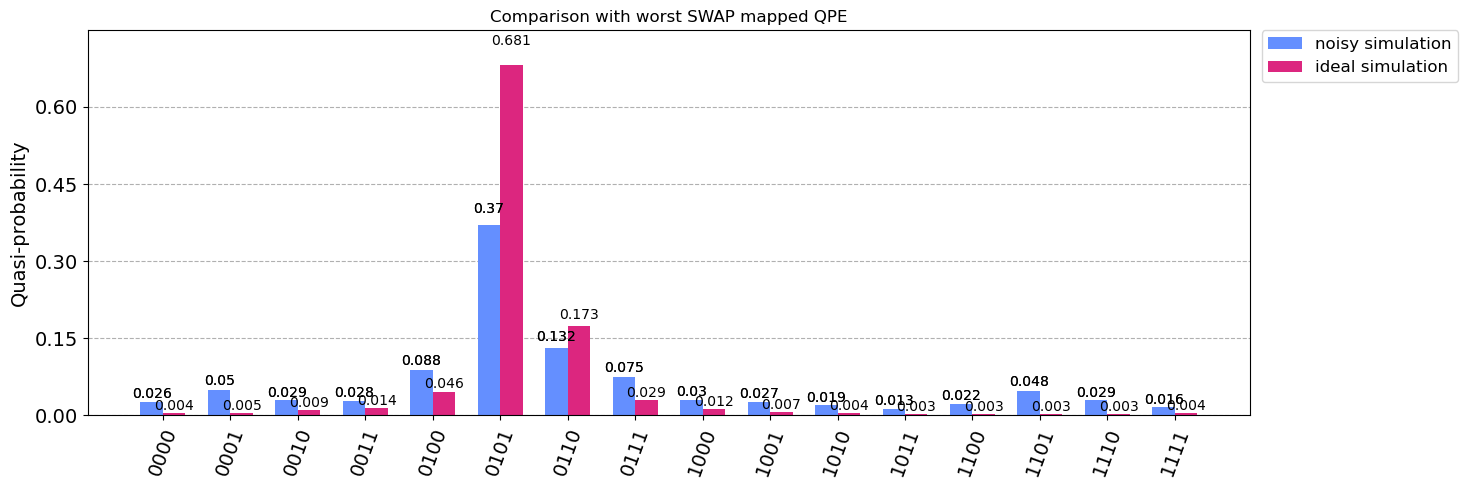

In [ ]:



print("histogram for maxmium depth")
job = backend_sim.run(qc4_out_max[-1], shots=8192)
print(job.job_id())
job_monitor(job)

output = job.result().get_counts()

legend = ['noisy simulation','ideal simulation']
plot_histogram([output,count_qc4], figsize=(15,5), legend= legend, title = 'Comparison with worst SWAP mapped QPE')








![](image/L3_QPE_final.png)

## Discussion

Going from an an accuracy of $2^{-2}$ to $2^{-3}$ changes the e value and decreases our chance to get the 'correct approximation' within the allowed error range. This is expected as we will get a phase value that is accurate to three biary digits instead of two binary digits, however at the same time it will become less probable to get the more accurate answer. 